# 电商用户行为分析与精准营销

## 导入所需库
本项目使用以下Python库进行数据分析：
- pandas & numpy：数据处理和数值计算
- sklearn：机器学习与聚类分析
- matplotlib & seaborn：基础数据可视化
- pyecharts：交互式图表可视化
- warnings：忽略警告信息

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyecharts.options as opts
from pyecharts.charts import Line, Radar, HeatMap, Bar, Pie, Scatter
from pyecharts.globals import ThemeType
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 设置seaborn样式
sns.set_style("whitegrid")
sns.set_palette("husl")

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# 配置中文字体
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 对于 pyecharts，设置全局字体
from pyecharts.globals import ThemeType
from pyecharts.globals import CurrentConfig
CurrentConfig.ONLINE_HOST = "https://cdn.jsdelivr.net/npm/echarts@latest/dist/"

# 1. 数据加载与初步分析
1. 加载原始数据并查看基本信息
2. 检查数据质量（缺失值、异常值等）
3. 分析数据的基本统计特征
4. 可视化关键分布特征


1. 数据基本信息:
------------------------------
数据维度: (30958, 5)

数据类型:
user_id         int64
item_id         int64
category_id     int64
behavior       object
timestamp       int64
dtype: object

前5行数据:
   user_id  item_id  category_id behavior   timestamp
0        1  2333346      2520771       pv  1511561733
1        1  2576651       149192       pv  1511572885
2        1  3830808      4181361       pv  1511593493
3        1  4365585      2520377       pv  1511596146
4        1  4606018      2735466       pv  1511616481

2. 数据质量检查:
------------------------------
缺失值统计:
user_id        0
item_id        0
category_id    0
behavior       0
timestamp      0
dtype: int64

重复行数: 0

3. 用户行为分布:
------------------------------
behavior
pv      27788
cart     1765
fav       767
buy       638
Name: count, dtype: int64


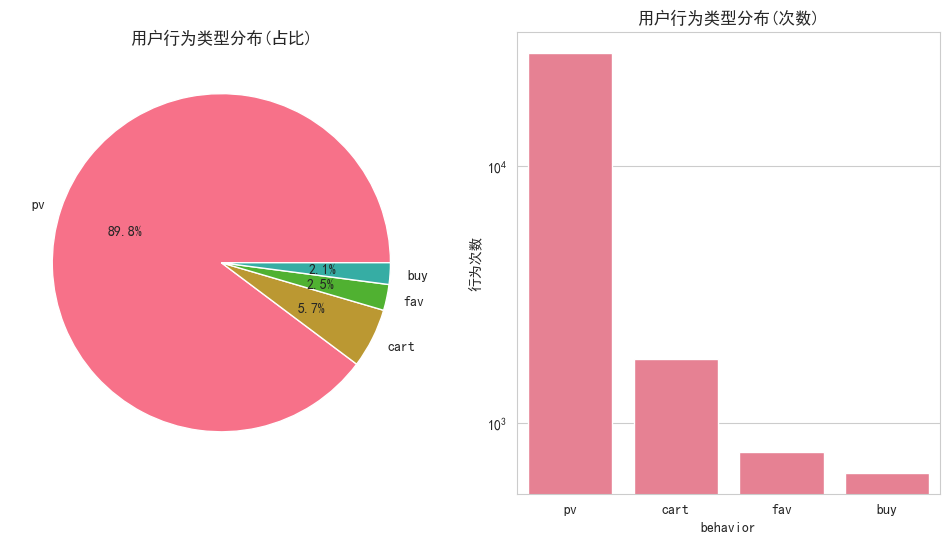


4. 行为详细统计:
------------------------------
   行为类型   行为次数  独立用户数   商品数量
0    pv  27788    294  20306
1  cart   1765    225   1705
2   fav    767    110    762
3   buy    638    203    603

用户行为转化漏斗图已保存为 '交互式图表/behavior_funnel.html'

5. 数值型特征统计描述:
------------------------------
            user_id       item_id   category_id     timestamp
count  3.095800e+04  3.095800e+04  3.095800e+04  3.095800e+04
mean   4.552703e+05  2.569648e+06  2.702615e+06  1.511960e+09
std    4.467247e+05  1.488441e+06  1.433485e+06  2.320437e+05
min    1.000000e+00  3.240000e+02  5.064000e+03  1.505118e+09
25%    1.002840e+05  1.300918e+06  1.379146e+06  1.511770e+09
50%    1.007620e+05  2.547726e+06  2.735466e+06  1.511961e+09
75%    1.000228e+06  3.856850e+06  4.022701e+06  1.512175e+09
max    1.000620e+06  5.162993e+06  5.150761e+06  1.512317e+09

6. 用户活跃度统计:
------------------------------
count    294.000000
mean     105.299320
std       90.054963
min        6.000000
25%       41.250000
50%       81.500000


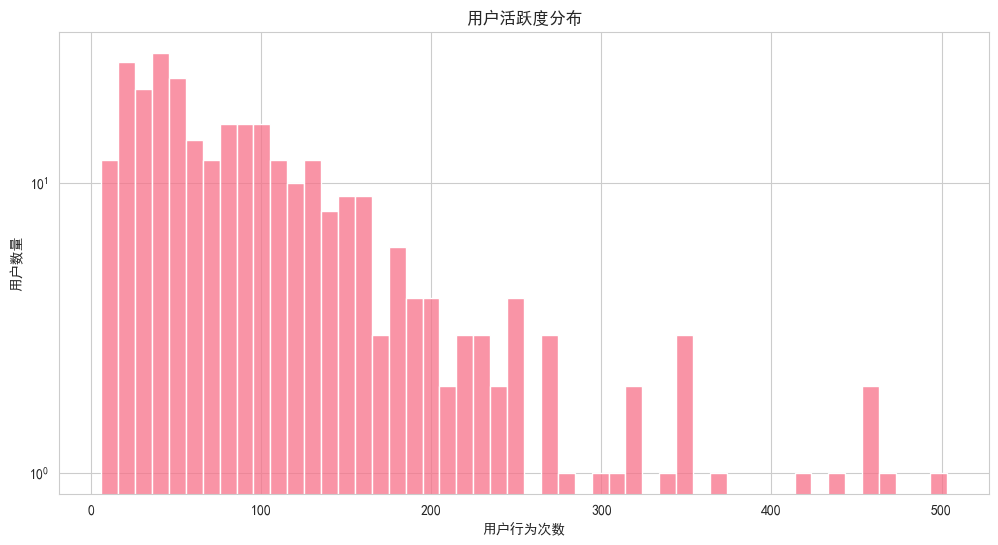

In [35]:
# 1.1 数据加载与初步分析

# 读取数据
df = pd.read_csv('UserBehavior1.csv', header=None, 
                 names=['user_id', 'item_id', 'category_id', 'behavior', 'timestamp'])

# 基础信息展示
print("\n1. 数据基本信息:")
print("-"*30)
print(f"数据维度: {df.shape}")
print(f"\n数据类型:\n{df.dtypes}")
print(f"\n前5行数据:\n{df.head()}")

# 数据质量检查
print("\n2. 数据质量检查:")
print("-"*30)
print("缺失值统计:")
print(df.isnull().sum())
print(f"\n重复行数: {df.duplicated().sum()}")

# 行为类型分析
behavior_counts = df['behavior'].value_counts()
print("\n3. 用户行为分布:")
print("-"*30)
print(behavior_counts)

# 可视化行为分布
plt.figure(figsize=(12, 6))

# 饼图
plt.subplot(1, 2, 1)
plt.pie(behavior_counts, labels=behavior_counts.index, autopct='%1.1f%%')
plt.title("用户行为类型分布(占比)")

# 条形图
plt.subplot(1, 2, 2)
sns.barplot(x=behavior_counts.index, y=behavior_counts.values)
plt.title("用户行为类型分布(次数)")
plt.ylabel("行为次数")
plt.yscale('log')
plt.show()
plt.close()

# 统计每种行为的用户数和商品数
behavior_stats = pd.DataFrame({
    '行为类型': behavior_counts.index,
    '行为次数': behavior_counts.values,
    '独立用户数': [df[df['behavior']==b]['user_id'].nunique() for b in behavior_counts.index],
    '商品数量': [df[df['behavior']==b]['item_id'].nunique() for b in behavior_counts.index]
})

print("\n4. 行为详细统计:")
print("-"*30)
print(behavior_stats)

# 绘制用户行为转化漏斗图
fig = go.Figure(go.Funnel(
    y=behavior_stats['行为类型'],
    x=behavior_stats['行为次数'],
    textinfo="value+percent previous"))

fig.update_layout(
    title_text="用户行为转化漏斗图",
    showlegend=True
)
fig.write_html("交互式图表/behavior_funnel.html")
print("\n用户行为转化漏斗图已保存为 '交互式图表/behavior_funnel.html'")

# 计算基础统计量
print("\n5. 数值型特征统计描述:")
print("-"*30)
print(df.describe())

# 分析用户活跃度
user_activity = df.groupby('user_id').size().describe()
print("\n6. 用户活跃度统计:")
print("-"*30)
print(user_activity)

# 可视化用户活跃度分布
plt.figure(figsize=(12, 6))
user_actions = df.groupby('user_id').size()
sns.histplot(user_actions, bins=50)
plt.title("用户活跃度分布")
plt.xlabel("用户行为次数")
plt.ylabel("用户数量")
plt.yscale('log')
plt.show()
plt.close()

# 2. 数据预处理与时间特征构建
1. 处理时间戳，转换为日期时间格式
2. 提取时间特征（小时、星期、日期等）
3. 分析时间模式
4. 可视化时间分布特征

缺失值统计：
user_id        0
item_id        0
category_id    0
behavior       0
timestamp      0
dtype: int64
重复行数量： 0
处理后的数据形状: (30958, 11)
处理后的数据缺失值统计：
user_id        0
item_id        0
category_id    0
behavior       0
timestamp      0
datetime       0
date           0
hour           0
day_of_week    0
week           0
day_part       0
dtype: int64
处理后的数据预览：
   user_id  item_id  category_id behavior   timestamp            datetime        date  hour  day_of_week  week day_part
0        1  2333346      2520771       pv  1511561733 2017-11-24 22:15:33  2017-11-24    22            4    47       深夜
1        1  2576651       149192       pv  1511572885 2017-11-25 01:21:25  2017-11-25     1            5    47       凌晨
2        1  3830808      4181361       pv  1511593493 2017-11-25 07:04:53  2017-11-25     7            5    47       上午
3        1  4365585      2520377       pv  1511596146 2017-11-25 07:49:06  2017-11-25     7            5    47       上午
4        1  4606018      2735466       pv

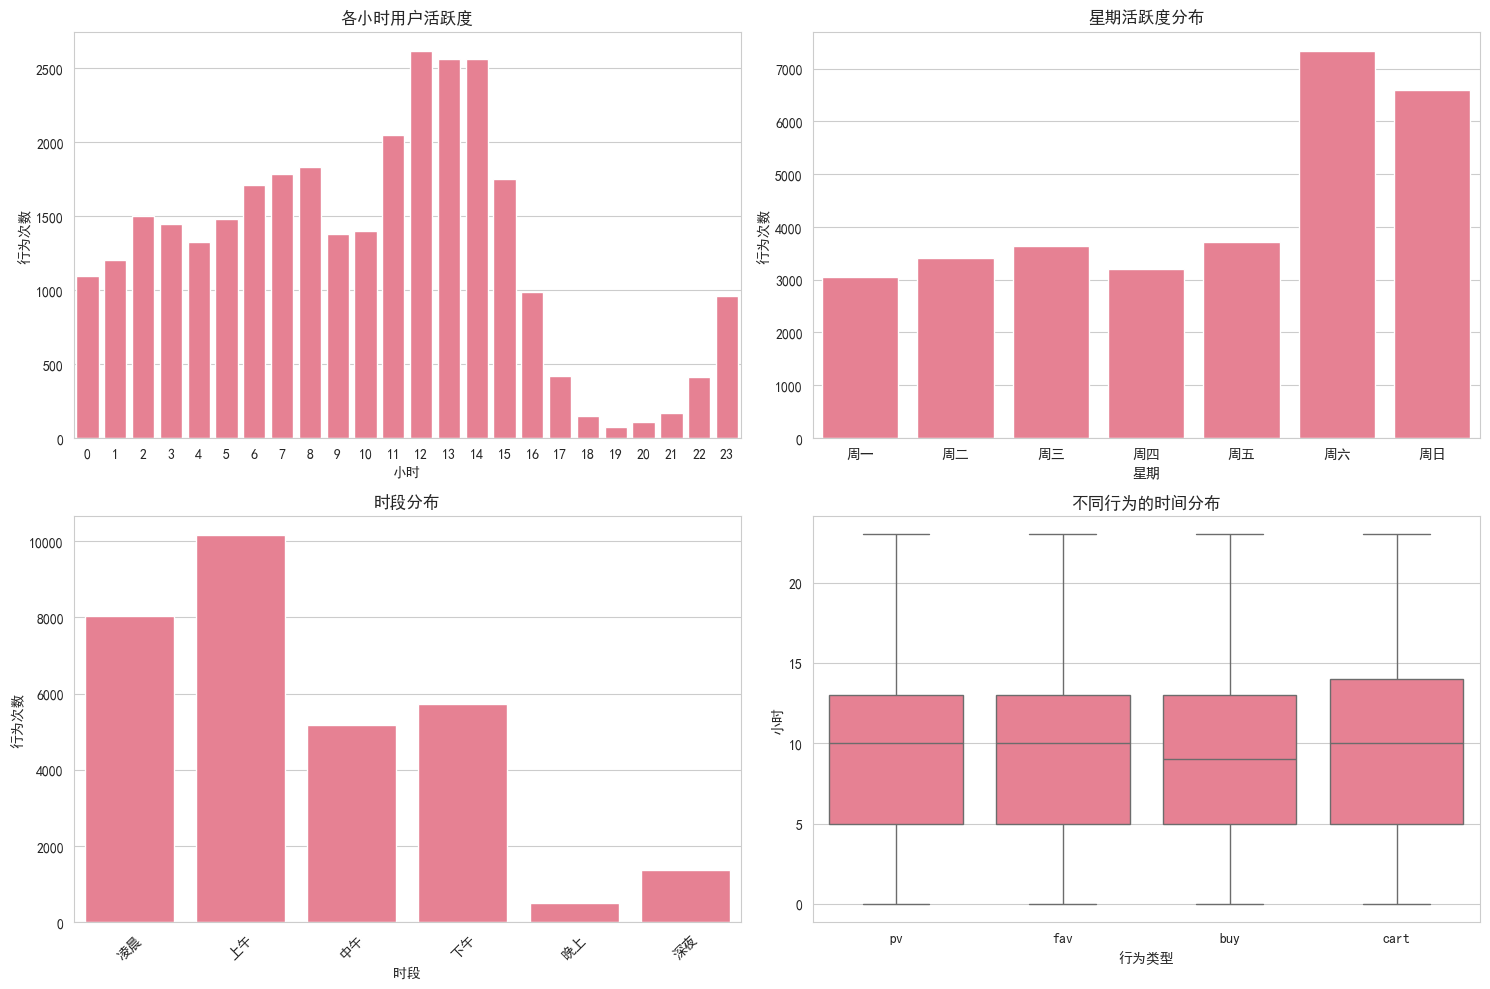

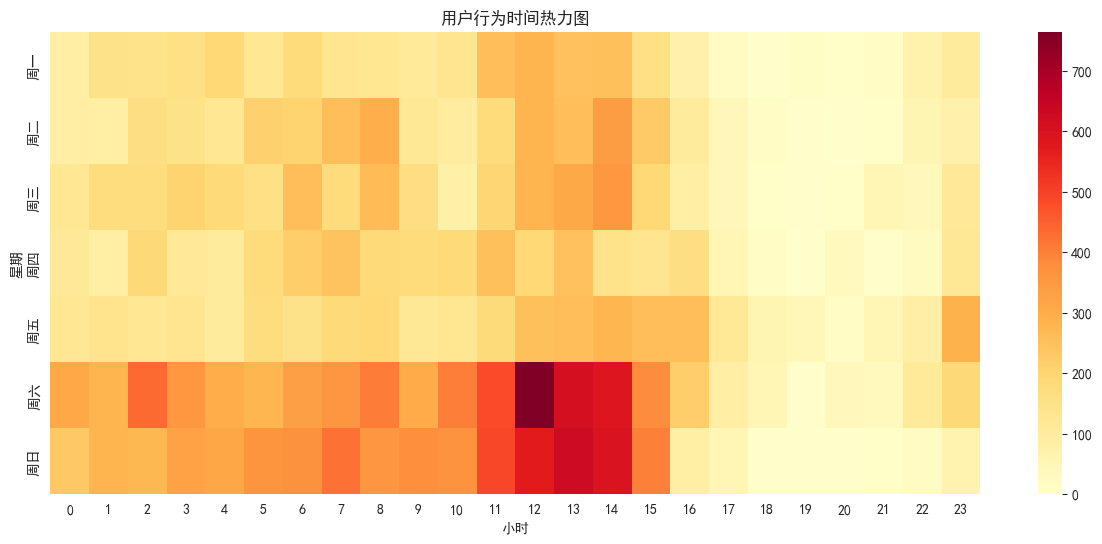

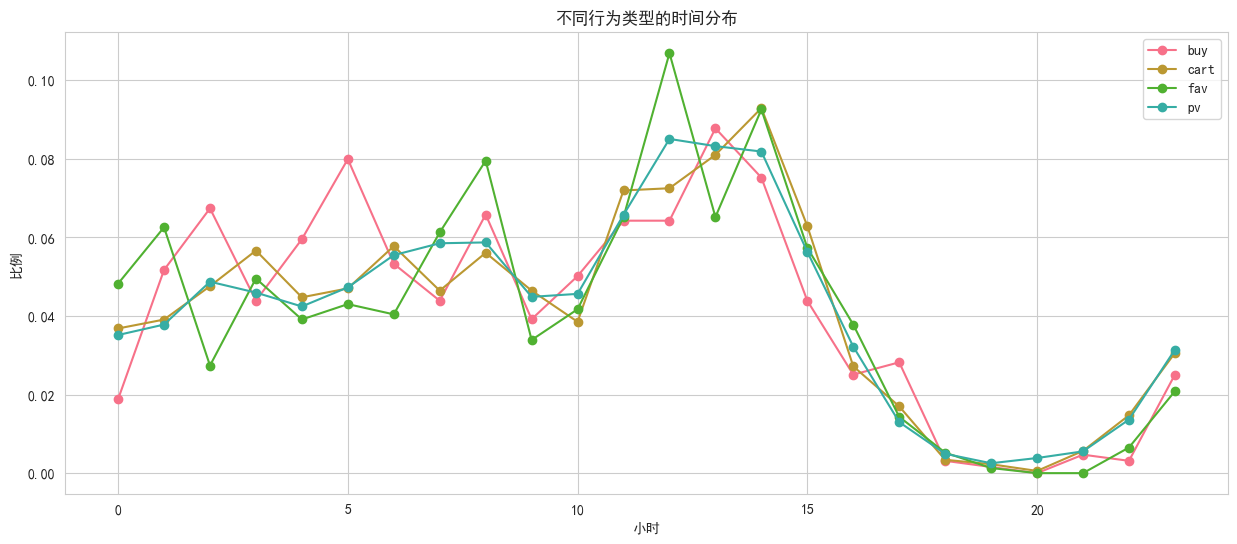

In [36]:
# 2. 数据预处理
# 检查缺失值
print("缺失值统计：")
print(df.isnull().sum())

# 检查重复值
print("重复行数量：", df.duplicated().sum())

# 处理时间戳
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['datetime'].dt.date              # 日期（如2017-11-24）
df['hour'] = df['datetime'].dt.hour              # 小时（0-23）
df['day_of_week'] = df['datetime'].dt.dayofweek  # 星期几（0=周一）
df['week'] = df['datetime'].dt.isocalendar().week  # 年内第几周
df['day_part'] = pd.cut(df['hour'], 
                       bins=[-1, 5, 11, 13, 17, 21, 23],
                       labels=['凌晨', '上午', '中午', '下午', '晚上', '深夜'])

# 显示处理后的数据
print("处理后的数据形状:" ,df.shape)
print("处理后的数据缺失值统计：")
print(df.isnull().sum())
print("处理后的数据预览：")
print(df.head())

# 检查数据的时间范围
print("数据时间范围：")
print(f"开始时间：{df['datetime'].min()}")
print(f"结束时间：{df['datetime'].max()}")
print(f"数据跨度：{(df['datetime'].max() - df['datetime'].min()).days} 天")

# 2.1 数据预处理与时间特征构建
print("="*50 + "\n数据预处理与时间特征分析\n" + "="*50)

# 处理时间戳
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['datetime'].dt.date        # 日期（如2017-11-24）
df['hour'] = df['datetime'].dt.hour        # 小时（0-23）
df['day_of_week'] = df['datetime'].dt.dayofweek  # 星期几（0=周一）
df['week'] = df['datetime'].dt.isocalendar().week  # 年内第几周
df['day_part'] = pd.cut(df['hour'], 
                       bins=[-1, 5, 11, 13, 17, 21, 23],
                       labels=['凌晨', '上午', '中午', '下午', '晚上', '深夜'])

# 显示处理后的数据
print("\n1. 处理后的数据预览:")
print("-"*30)
print(df.head())

# 分析时间跨度
time_span = df['datetime'].agg(['min', 'max'])
print("\n2. 数据时间范围:")
print("-"*30)
print(f"开始时间：{time_span['min']}")
print(f"结束时间：{time_span['max']}")
print(f"数据跨度：{(time_span['max'] - time_span['min']).days} 天")

# 分析每天的行为分布
daily_behavior = df.groupby(['date', 'behavior'])['user_id'].count().unstack()
print("\n3. 每日行为统计:")
print("-"*30)
print(daily_behavior.describe())

# 可视化时间分布特征
plt.figure(figsize=(15, 10))

# 1. 小时分布
plt.subplot(2, 2, 1)
hourly_dist = df.groupby('hour')['user_id'].count()
sns.barplot(x=hourly_dist.index, y=hourly_dist.values)
plt.title("各小时用户活跃度")
plt.xlabel("小时")
plt.ylabel("行为次数")

# 2. 星期分布
plt.subplot(2, 2, 2)
weekday_dist = df.groupby('day_of_week')['user_id'].count()
sns.barplot(x=['周一','周二','周三','周四','周五','周六','周日'], 
            y=weekday_dist.values)
plt.title("星期活跃度分布")
plt.xlabel("星期")
plt.ylabel("行为次数")

# 3. 时段分布
plt.subplot(2, 2, 3)
daypart_dist = df.groupby('day_part')['user_id'].count()
sns.barplot(x=daypart_dist.index, y=daypart_dist.values)
plt.title("时段分布")
plt.xlabel("时段")
plt.ylabel("行为次数")
plt.xticks(rotation=45)

# 4. 行为类型的时间分布
plt.subplot(2, 2, 4)
sns.boxplot(x='behavior', y='hour', data=df)
plt.title("不同行为的时间分布")
plt.xlabel("行为类型")
plt.ylabel("小时")

plt.tight_layout()
plt.show()
plt.close()

# 创建热力图分析行为时间模式
pivot_hour_weekday = df.pivot_table(
    values='user_id', 
    index='day_of_week',
    columns='hour',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(15, 6))
sns.heatmap(pivot_hour_weekday, 
            cmap='YlOrRd',
            yticklabels=['周一','周二','周三','周四','周五','周六','周日'])
plt.title("用户行为时间热力图")
plt.xlabel("小时")
plt.ylabel("星期")
plt.show()
plt.close()

# 分析不同行为类型的时间模式
behavior_hour = pd.crosstab(df['behavior'], df['hour'])
behavior_hour_pct = behavior_hour.div(behavior_hour.sum(axis=1), axis=0)

plt.figure(figsize=(15, 6))
for behavior in behavior_hour_pct.index:
    plt.plot(behavior_hour_pct.columns, behavior_hour_pct.loc[behavior], 
             label=behavior, marker='o')
plt.title("不同行为类型的时间分布")
plt.xlabel("小时")
plt.ylabel("比例")
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# 3. 用户行为特征工程
1. 基础行为特征（浏览、购买、加购、收藏次数）
2. 时间维度特征（活跃天数、时段活跃度）
3. 转化率特征（购买率、加购率等）
4. 消费习惯特征（客单价、品类偏好等）
5. 活跃度特征（访问间隔、访问频率等）

用户特征矩阵形状: (294, 11)
特征前5行:
         pv  buy  cart  fav  total_actions  buy_ratio  cart_ratio  fav_ratio  active_days  night_actions  weekend_actions
user_id                                                                                                                  
1        54    0     0    0             54   0.000000    0.000000   0.000000           10           23.0               19
100      84    8     0    6             98   0.095238    0.000000   0.071429            9           36.0               21
1000     67    0     2   12             81   0.000000    0.029851   0.179104            9           25.0               31
10001    21    0     0    0             21   0.000000    0.000000   0.000000            4            8.0               16
10008    41    3    12    0             56   0.073171    0.292683   0.000000            7           43.0               18
用户行为特征工程

1. 用户特征矩阵概览:
------------------------------
特征矩阵维度: (294, 19)

2. 特征统计描述:
------------------------------
beha

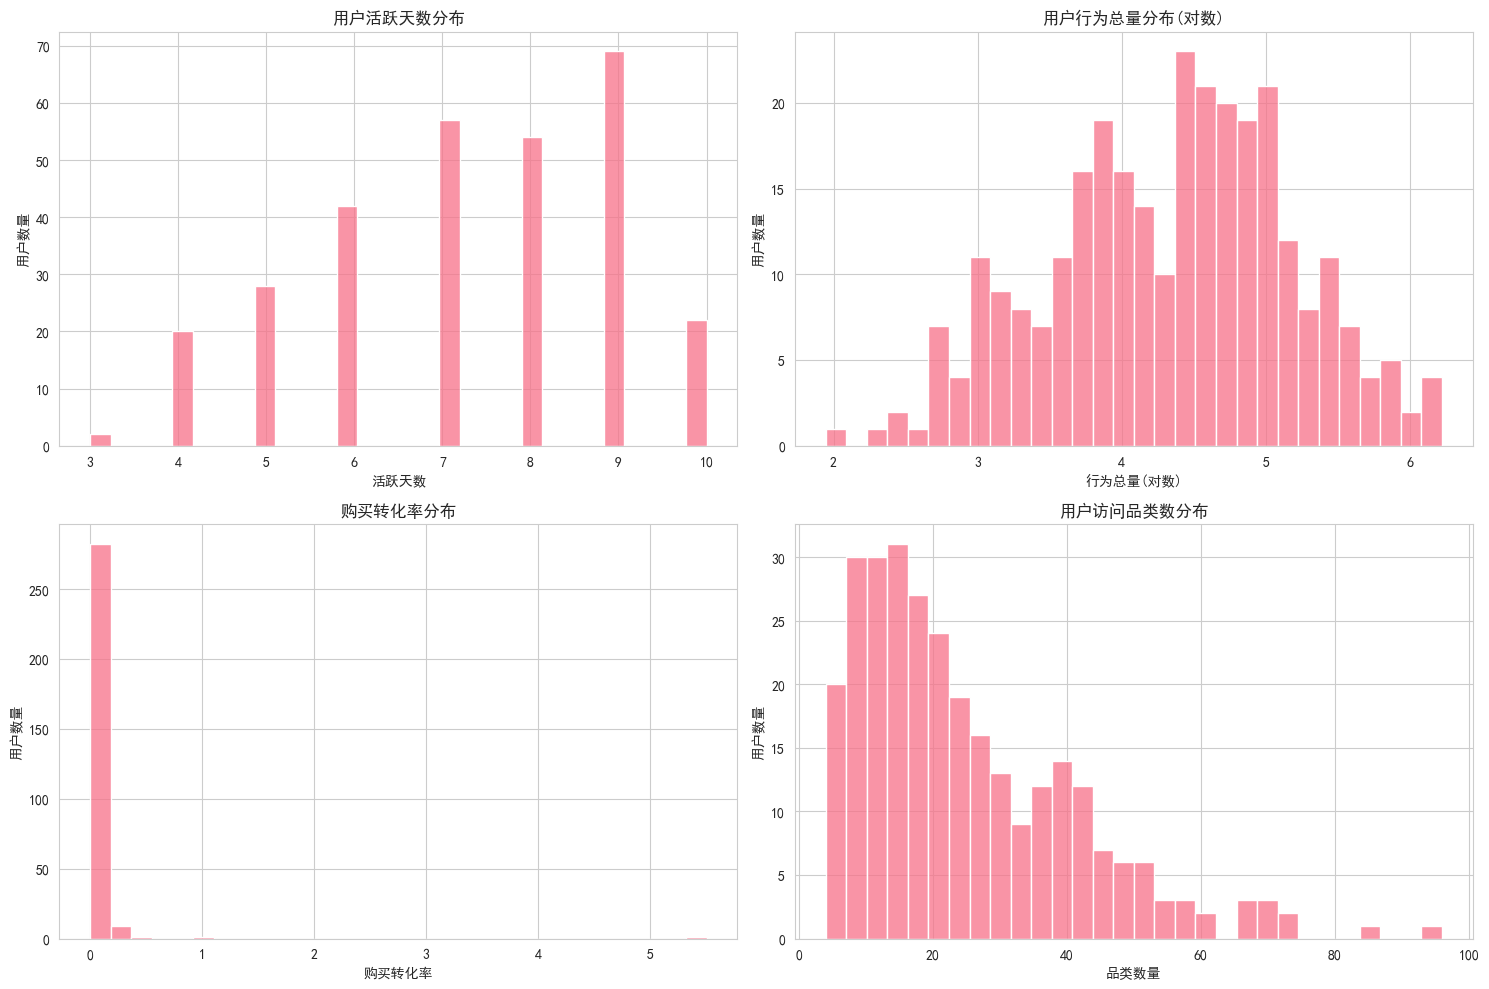

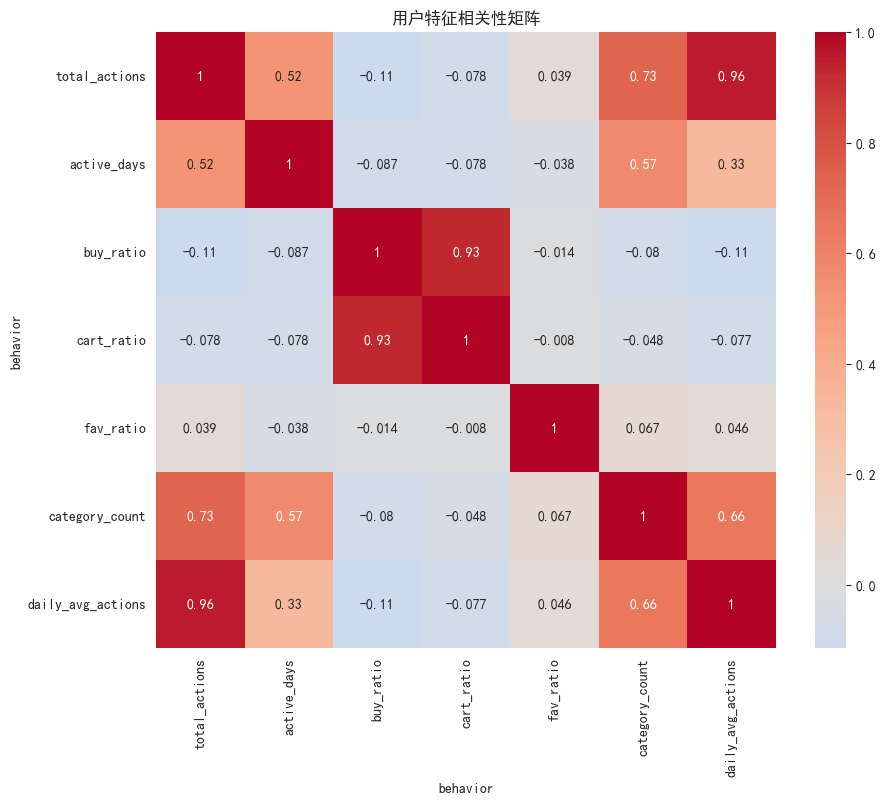

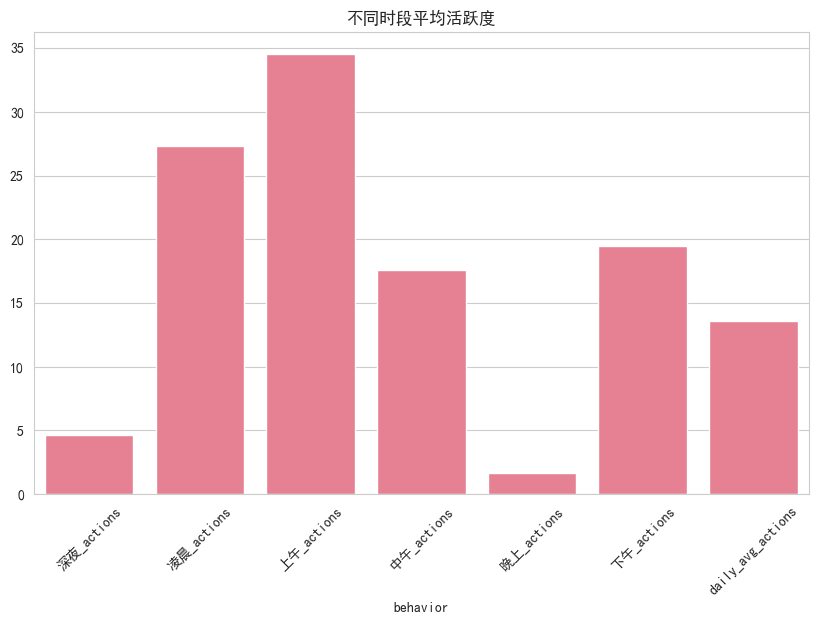


3. 用户行为特征构建完成
------------------------------
构建特征数量: 19
特征列表:
- pv
- buy
- cart
- fav
- total_actions
- active_days
- 深夜_actions
- 凌晨_actions
- 上午_actions
- 中午_actions
- 晚上_actions
- 下午_actions
- buy_ratio
- cart_ratio
- fav_ratio
- category_count
- favorite_category
- avg_visit_interval
- daily_avg_actions


In [37]:
# 3. 特征工程 - 用户行为特征
# 用户行为透视表
user_behavior = pd.crosstab(df['user_id'], df['behavior'])
# 确保列名正确
behavior_types = ['pv', 'buy', 'cart', 'fav']
for bt in behavior_types:
    if bt not in user_behavior.columns:
        user_behavior[bt] = 0

user_behavior = user_behavior[behavior_types]

# 计算用户总行为次数
user_behavior['total_actions'] = user_behavior.sum(axis=1)

# 计算转化率特征
user_behavior['buy_ratio'] = user_behavior['buy'] / user_behavior['pv']
user_behavior['cart_ratio'] = user_behavior['cart'] / user_behavior['pv']
user_behavior['fav_ratio'] = user_behavior['fav'] / user_behavior['pv']

# 处理无穷大值（当pv为0时）
user_behavior.replace([np.inf, -np.inf], 0, inplace=True)
user_behavior.fillna(0, inplace=True)

# 添加活跃天数特征
active_days = df.groupby('user_id')['date'].nunique()
user_behavior = user_behavior.join(active_days.rename('active_days'))

# 添加时段特征（夜间活跃度：22点-6点）
night_df = df[(df['hour'] >= 22) | (df['hour'] < 6)]
night_activity = night_df.groupby('user_id')['behavior'].count().rename('night_actions')
user_behavior = user_behavior.join(night_activity, how='left').fillna(0)

# 添加周末活跃度
weekend_df = df[df['day_of_week'].isin([5, 6])]  # 周六和周日
weekend_activity = weekend_df.groupby('user_id')['behavior'].count().rename('weekend_actions')
user_behavior = user_behavior.join(weekend_activity, how='left').fillna(0)

print(f"用户特征矩阵形状: {user_behavior.shape}")
print(f"特征前5行:\n{user_behavior.head()}")

# 3.1 用户行为特征构建
print("="*50 + "\n用户行为特征工程\n" + "="*50)

# 1. 基础行为特征
user_behavior = pd.crosstab(df['user_id'], df['behavior'])
behavior_types = ['pv', 'buy', 'cart', 'fav']
for bt in behavior_types:
    if bt not in user_behavior.columns:
        user_behavior[bt] = 0

user_behavior = user_behavior[behavior_types]
user_behavior['total_actions'] = user_behavior.sum(axis=1)

# 2. 时间维度特征
active_days = df.groupby('user_id')['date'].nunique()
user_behavior['active_days'] = active_days

# 计算每个时段的活跃度
for part in df['day_part'].unique():
    temp_df = df[df['day_part'] == part]
    part_activity = temp_df.groupby('user_id')['behavior'].count()
    user_behavior[f'{part}_actions'] = part_activity

# 3. 转化率特征
user_behavior['buy_ratio'] = user_behavior['buy'] / user_behavior['pv']
user_behavior['cart_ratio'] = user_behavior['cart'] / user_behavior['pv']
user_behavior['fav_ratio'] = user_behavior['fav'] / user_behavior['pv']

# 处理无穷大值
user_behavior.replace([np.inf, -np.inf], 0, inplace=True)
user_behavior.fillna(0, inplace=True)

# 4. 消费习惯特征
# 统计用户的品类数量
category_count = df.groupby('user_id')['category_id'].nunique()
user_behavior['category_count'] = category_count

# 最常访问的品类
most_visited_category = df.groupby(['user_id', 'category_id'])['behavior'].count()\
                         .reset_index()
most_visited_category = most_visited_category.sort_values(['user_id', 'behavior'], 
                                                        ascending=[True, False])
most_visited_category = most_visited_category.groupby('user_id').first()
user_behavior['favorite_category'] = most_visited_category['category_id']

# 5. 活跃度特征
# 计算访问间隔
user_visits = df.groupby(['user_id', 'date'])['behavior'].count().reset_index()
user_visits = user_visits.sort_values(['user_id', 'date'])
visit_intervals = user_visits.groupby('user_id')['date'].agg(lambda x: np.diff(x).mean())
user_behavior['avg_visit_interval'] = visit_intervals

# 计算每日平均行为次数
user_behavior['daily_avg_actions'] = user_behavior['total_actions'] / user_behavior['active_days']

print("\n1. 用户特征矩阵概览:")
print("-"*30)
print(f"特征矩阵维度: {user_behavior.shape}")
print("\n2. 特征统计描述:")
print("-"*30)
print(user_behavior.describe())

# 可视化分析
plt.figure(figsize=(15, 10))

# 1. 用户活跃天数分布
plt.subplot(2, 2, 1)
sns.histplot(data=user_behavior['active_days'], bins=30)
plt.title("用户活跃天数分布")
plt.xlabel("活跃天数")
plt.ylabel("用户数量")

# 2. 用户行为总量分布
plt.subplot(2, 2, 2)
sns.histplot(data=np.log1p(user_behavior['total_actions']), bins=30)
plt.title("用户行为总量分布(对数)")
plt.xlabel("行为总量(对数)")
plt.ylabel("用户数量")

# 3. 用户购买转化率分布
plt.subplot(2, 2, 3)
sns.histplot(data=user_behavior['buy_ratio'], bins=30)
plt.title("购买转化率分布")
plt.xlabel("购买转化率")
plt.ylabel("用户数量")

# 4. 品类数量分布
plt.subplot(2, 2, 4)
sns.histplot(data=user_behavior['category_count'], bins=30)
plt.title("用户访问品类数分布")
plt.xlabel("品类数量")
plt.ylabel("用户数量")

plt.tight_layout()
plt.show()
plt.close()

# 特征相关性分析
correlation_features = ['total_actions', 'active_days', 'buy_ratio', 
                       'cart_ratio', 'fav_ratio', 'category_count', 
                       'daily_avg_actions']
correlation_matrix = user_behavior[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("用户特征相关性矩阵")
plt.show()
plt.close()

# 时段活跃度分析
time_features = [col for col in user_behavior.columns if 'actions' in col and col != 'total_actions']
time_patterns = user_behavior[time_features].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=time_patterns.index, y=time_patterns.values)
plt.title("不同时段平均活跃度")
plt.xticks(rotation=45)
plt.show()
plt.close()

print("\n3. 用户行为特征构建完成")
print("-"*30)
print(f"构建特征数量: {user_behavior.shape[1]}")
print("特征列表:")
for col in user_behavior.columns:
    print(f"- {col}")


# 4. 商品特征工程
1. 基础行为特征（浏览、购买、加购、收藏次数）
2. 商品热度特征（总访问量、独立访客数）
3. 转化率特征（购买率、加购率等）
4. 时间维度特征（上架时长、活跃天数等）
5. 用户偏好特征（用户画像、复购率等）

商品特征矩阵形状: (21688, 9)
特征前5行:
         pv  buy  cart  fav  total_actions  buy_ratio  cart_ratio  fav_ratio  unique_users
item_id                                                                                   
324       1    0     0    0              1        0.0         0.0        0.0             1
434       1    0     0    0              1        0.0         0.0        0.0             1
518       1    0     0    0              1        0.0         0.0        0.0             1
807       3    0     0    0              3        0.0         0.0        0.0             1
812       2    0     0    0              2        0.0         0.0        0.0             1

1. 商品特征矩阵概览:
------------------------------
特征矩阵维度: (21688, 19)

2. 特征统计描述:
------------------------------
behavior            pv           buy          cart           fav  total_actions  unique_users   active_days     buy_ratio    cart_ratio     fav_ratio   深夜_actions   凌晨_actions   上午_actions   中午_actions  晚上_actions   下午_actions 

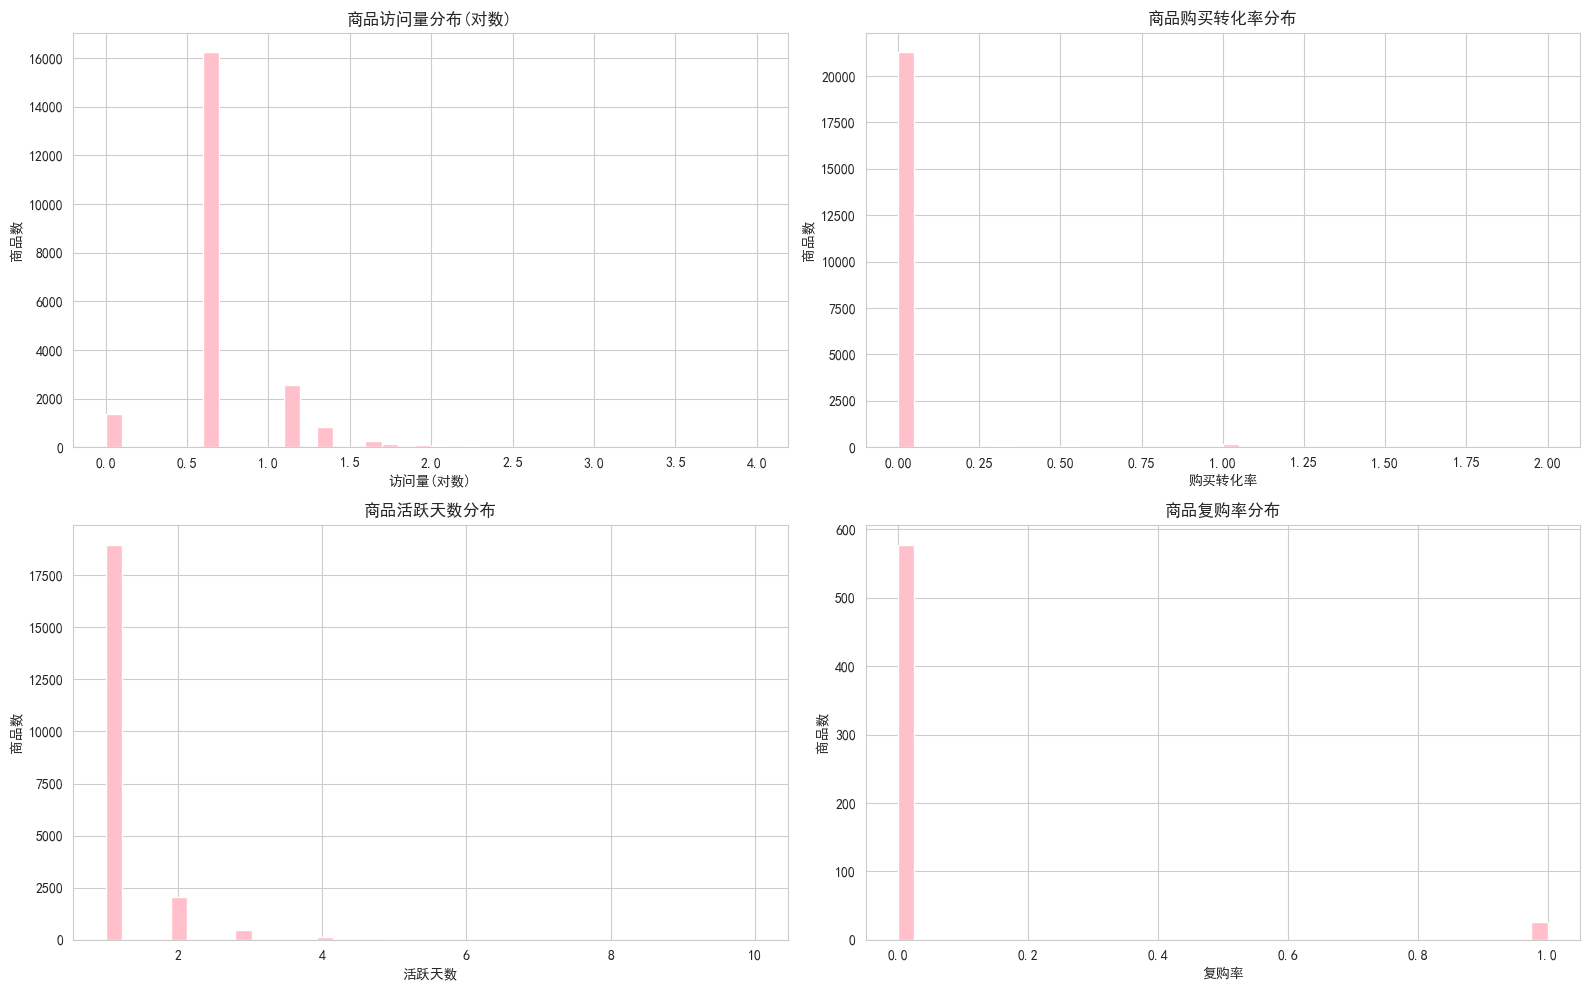

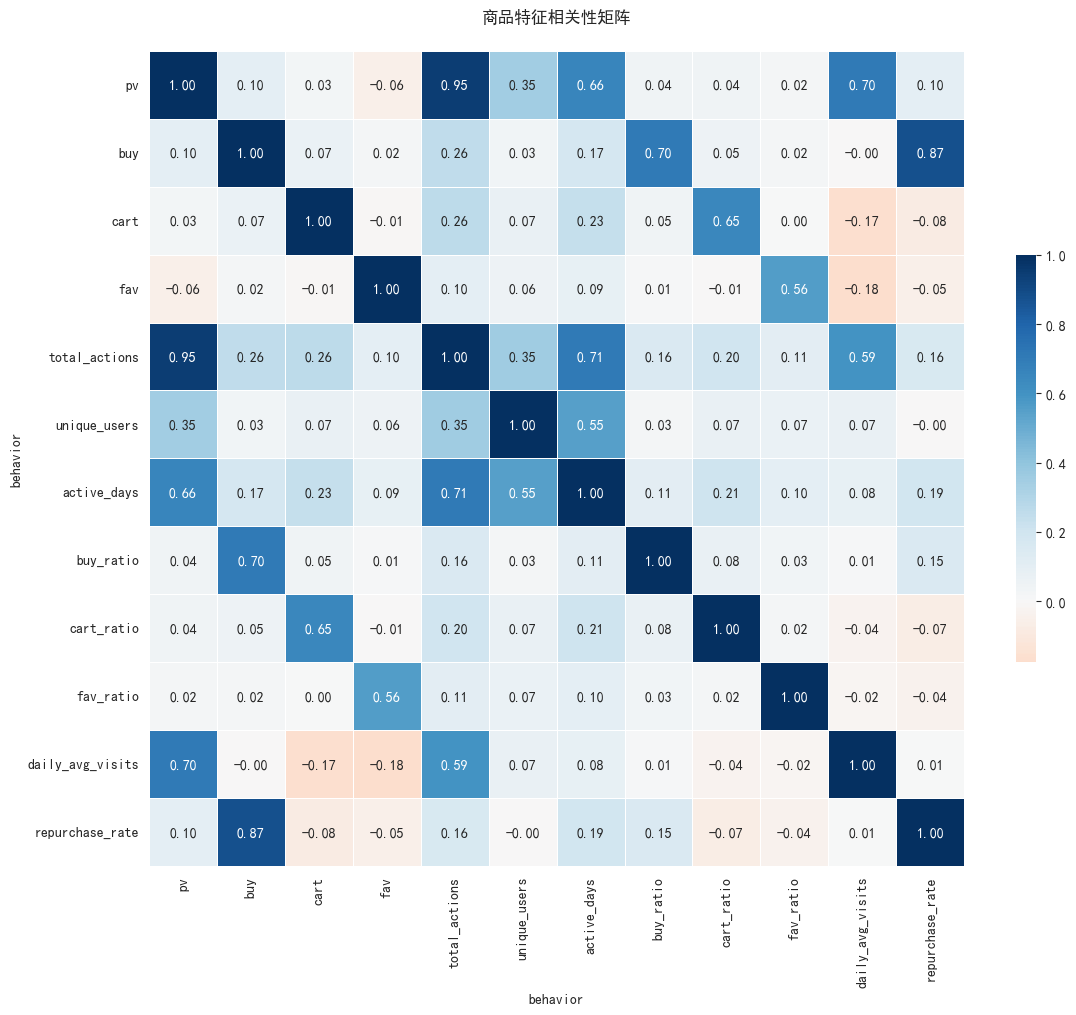


3. 商品类别统计:
------------------------------
behavior          用户数   商品数   行为数
category_id                      
4756105      1.180425  1342  1448
3607361      1.241611  1215  1277
4145813      1.085754   999  1099
982926       1.092564   878   969
2355072      1.108929   779   841

4. 商品特征构建完成
------------------------------
构建特征数量: 19
特征列表:
- pv
- buy
- cart
- fav
- total_actions
- unique_users
- active_days
- buy_ratio
- cart_ratio
- fav_ratio
- 深夜_actions
- 凌晨_actions
- 上午_actions
- 中午_actions
- 晚上_actions
- 下午_actions
- daily_avg_visits
- repurchase_rate
- category_id


In [38]:
# 4. 商品特征工程
# 商品行为透视表
item_behavior = pd.crosstab(df['item_id'], df['behavior'])
for bt in behavior_types:
    if bt not in item_behavior.columns:
        item_behavior[bt] = 0
item_behavior = item_behavior[behavior_types]

# 计算商品总行为次数
item_behavior['total_actions'] = item_behavior.sum(axis=1)

# 计算转化率特征
item_behavior['buy_ratio'] = item_behavior['buy'] / item_behavior['pv']
item_behavior['cart_ratio'] = item_behavior['cart'] / item_behavior['pv']
item_behavior['fav_ratio'] = item_behavior['fav'] / item_behavior['pv']

# 处理无穷大值
item_behavior.replace([np.inf, -np.inf], 0, inplace=True)
item_behavior.fillna(0, inplace=True)

# 添加商品被不同用户接触次数
unique_users = df.groupby('item_id')['user_id'].nunique().rename('unique_users')
item_behavior = item_behavior.join(unique_users)
print(f"商品特征矩阵形状: {item_behavior.shape}")
print(f"特征前5行:\n{item_behavior.head()}")

# 4.1 商品行为特征构建

# 1. 基础行为特征
item_behavior = pd.crosstab(df['item_id'], df['behavior'])
for bt in behavior_types:
    if bt not in item_behavior.columns:
        item_behavior[bt] = 0
item_behavior = item_behavior[behavior_types]

# 计算总行为次数
item_behavior['total_actions'] = item_behavior.sum(axis=1)

# 2. 商品热度特征
# 统计独立访客数
unique_users = df.groupby('item_id')['user_id'].nunique().rename('unique_users')
item_behavior['unique_users'] = unique_users

# 活跃天数
item_active_days = df.groupby('item_id')['date'].nunique()
item_behavior['active_days'] = item_active_days

# 3. 转化率特征
item_behavior['buy_ratio'] = item_behavior['buy'] / item_behavior['pv']
item_behavior['cart_ratio'] = item_behavior['cart'] / item_behavior['pv']
item_behavior['fav_ratio'] = item_behavior['fav'] / item_behavior['pv']

# 处理无穷大值
item_behavior.replace([np.inf, -np.inf], 0, inplace=True)
item_behavior.fillna(0, inplace=True)

# 4. 时间维度特征
# 计算每个时段的活跃度
for part in df['day_part'].unique():
    temp_df = df[df['day_part'] == part]
    part_activity = temp_df.groupby('item_id')['behavior'].count()
    item_behavior[f'{part}_actions'] = part_activity.fillna(0)

# 日均访问量
item_behavior['daily_avg_visits'] = item_behavior['pv'] / item_behavior['active_days']

# 5. 用户偏好特征
# 复购率（重复购买的用户比例）
def calculate_repurchase_rate(group):
    if len(group) == 0:
        return 0
    total_users = group['user_id'].nunique()
    repeat_users = group.groupby('user_id').size()
    repeat_users = (repeat_users > 1).sum()
    return repeat_users / total_users

buy_data = df[df['behavior'] == 'buy']
repurchase_rate = buy_data.groupby('item_id').apply(calculate_repurchase_rate)
item_behavior['repurchase_rate'] = repurchase_rate

# 商品所属类别
item_category = df.groupby('item_id')['category_id'].first()
item_behavior['category_id'] = item_category

print("\n1. 商品特征矩阵概览:")
print("-"*30)
print(f"特征矩阵维度: {item_behavior.shape}")
print("\n2. 特征统计描述:")
print("-"*30)
print(item_behavior.describe())

# 可视化分析
plt.figure(figsize=(16, 10))

# 1. 商品访问量分布
plt.subplot(221)
plt.title('商品访问量分布(对数)')
plt.hist(item_behavior['pv'].apply(lambda x: np.log1p(x)), bins=40, color='pink')
plt.xlabel('访问量(对数)')
plt.ylabel('商品数')

# 2. 商品购买转化率分布
plt.subplot(222)
plt.title('商品购买转化率分布')
plt.hist(item_behavior['buy_ratio'], bins=40, color='pink')
plt.xlabel('购买转化率')
plt.ylabel('商品数')

# 3. 商品活跃天数分布
plt.subplot(223)
plt.title('商品活跃天数分布')
plt.hist(item_behavior['active_days'], bins=40, color='pink')
plt.xlabel('活跃天数')
plt.ylabel('商品数')

# 4. 复购率分布
plt.subplot(224)
plt.title('商品复购率分布')
plt.hist(item_behavior['repurchase_rate'], bins=40, color='pink')
plt.xlabel('复购率')
plt.ylabel('商品数')

plt.tight_layout()
plt.show()

# 商品特征相关性分析
behavior_features = ['pv', 'buy', 'cart', 'fav', 'total_actions', 'unique_users', 'active_days', 'buy_ratio', 'cart_ratio', 'fav_ratio', 'daily_avg_visits', 'repurchase_rate']

plt.figure(figsize=(12, 10))
sns.heatmap(item_behavior[behavior_features].corr(), 
            annot=True,             # 显示数值标注
            fmt='.2f',             # 数值格式为2位小数
            cmap='RdBu',           # 使用红蓝配色方案
            center=0,              # 相关系数的中心点为0
            square=True,           # 设置为正方形显示
            linewidths=0.5,        # 添加网格线
            cbar_kws={"shrink": .5})  # 调整颜色条大小
plt.title('商品特征相关性矩阵', pad=20)  # 调整标题位置
plt.tight_layout()  # 自动调整布局
plt.show()

print("\n3. 商品类别统计:")
print("-" * 30)
category_stats = item_behavior.groupby('category_id').agg({
    'unique_users': 'mean',
    'pv': 'sum',
    'total_actions': 'sum'
}).rename(columns={
    'unique_users': '用户数',
    'pv': '商品数',
    'total_actions': '行为数'
}).sort_values('行为数', ascending=False)

print(category_stats.head())

print("\n4. 商品特征构建完成")
print("-" * 30)
item_features = list(item_behavior.columns)
print(f"构建特征数量: {len(item_features)}")
print("特征列表:")
for feature in item_features:
    print(f"- {feature}")


# 5. 用户聚类分析
1. 特征选择与预处理
2. 最佳聚类数确定（肘部法则、轮廓系数）
3. KMeans聚类模型训练
4. 聚类结果评估与可视化
5. 用户群特征画像分析


可用的特征列：
------------------------------
['pv', 'buy', 'cart', 'fav', 'total_actions', 'active_days', '深夜_actions', '凌晨_actions', '上午_actions', '中午_actions', '晚上_actions', '下午_actions', 'buy_ratio', 'cart_ratio', 'fav_ratio', 'category_count', 'favorite_category', 'avg_visit_interval', 'daily_avg_actions']

选择的特征:
------------------------------
- pv
- buy
- cart
- fav
- active_days
- total_actions
- buy_ratio
- cart_ratio
- fav_ratio

最佳聚类数: 3
对应轮廓系数: 0.3921

聚类结果统计:
------------------------------

各群组规模：
cluster
0     64
1    229
2      1
Name: count, dtype: int64

群组特征均值：
behavior         pv        buy       cart       fav  active_days  total_actions  buy_ratio  cart_ratio  fav_ratio
cluster                                                                                                          
0         211.28125   3.796875  14.859375  5.609375     8.765625     235.546875   0.022729    0.086752   0.027452
1          62.28821   1.676856   3.506550  1.781659     6.912664      69.25327

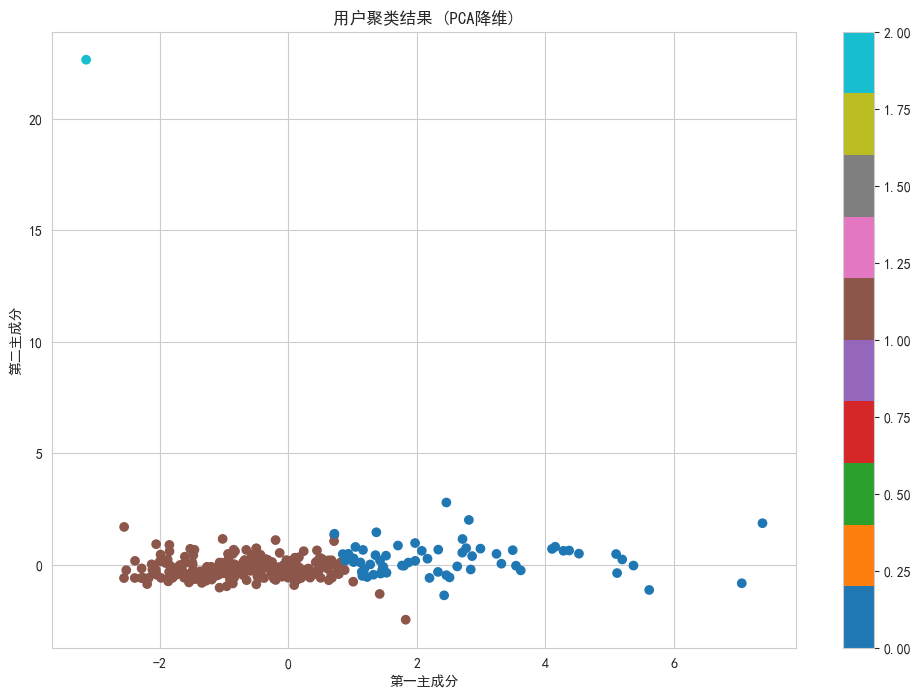

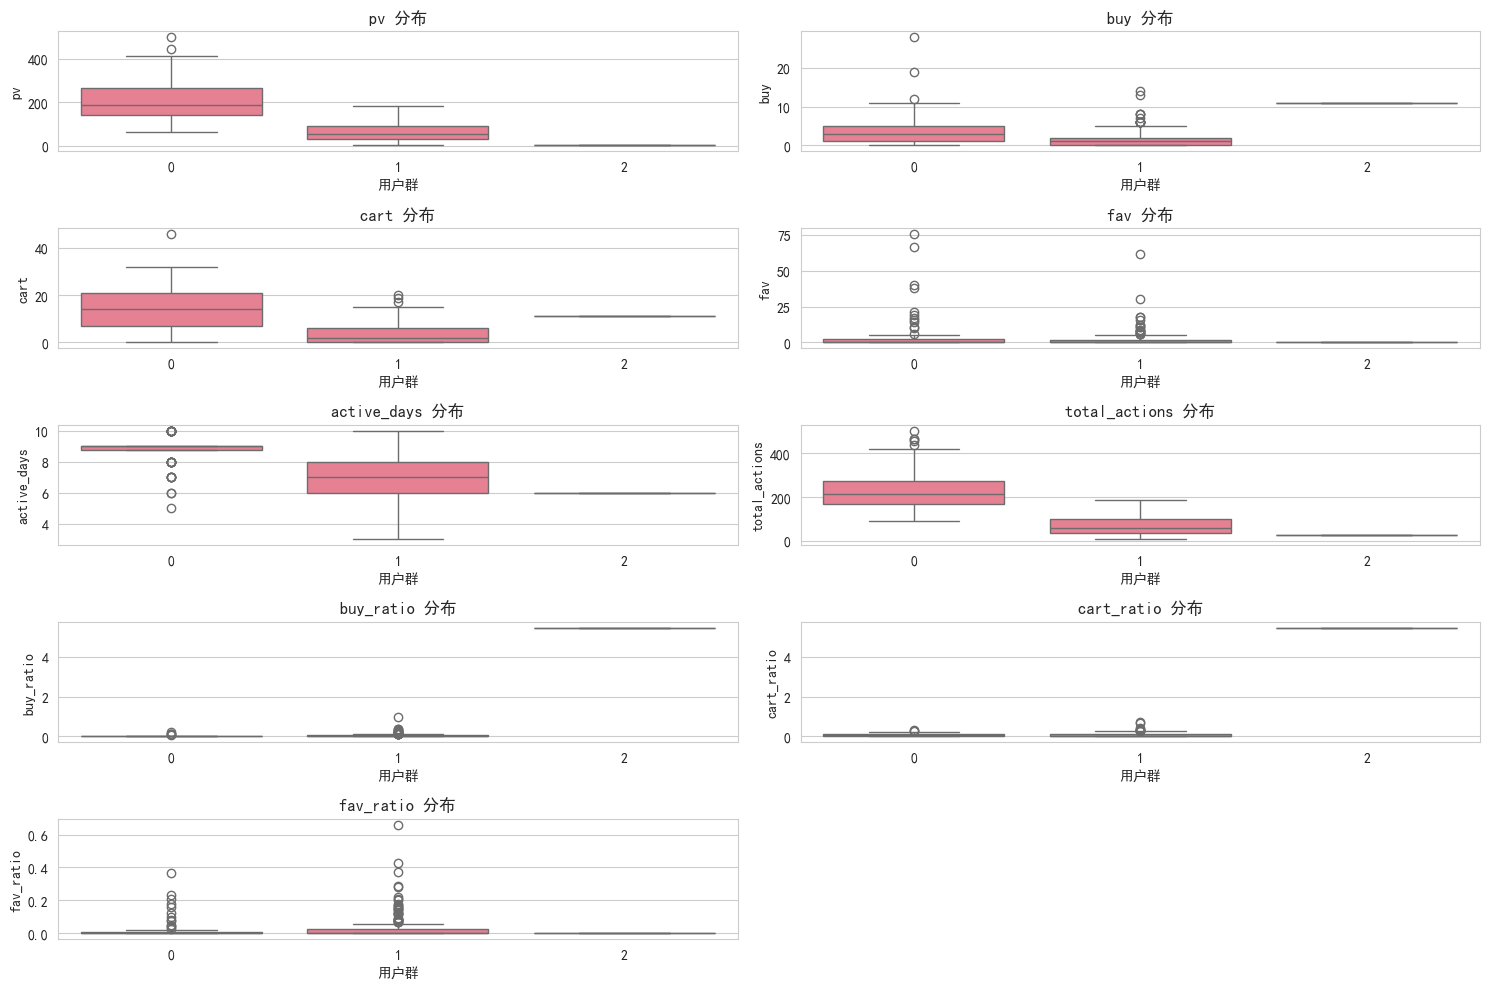


用户群体特征总结:

群组 0 (64人, 21.8%)
------------------------------
显著特征：
- cart: 高于平均水平 147.5%
- total_actions: 高于平均水平 123.7%
- pv: 高于平均水平 123.5%

群组 1 (229人, 77.9%)
------------------------------
显著特征：
- cart: 低于平均水平 41.6%
- total_actions: 低于平均水平 34.2%
- pv: 低于平均水平 34.1%

群组 2 (1人, 0.3%)
------------------------------
显著特征：
- buy_ratio: 高于平均水平 9381.5%
- cart_ratio: 高于平均水平 5823.6%
- buy: 高于平均水平 406.9%

用户聚类分析完成。
------------------------------
- 生成的群组数：3
- 可视化结果已保存：
交互式图表/clustering_metrics.html
交互式图表/user_clusters_radar.html


In [39]:
# 5.1 用户聚类分析
# 检查可用的特征列
from sklearn.decomposition import PCA


print("\n可用的特征列：")
print("-"*30)
print(user_behavior.columns.tolist())

# 1. 特征选择与预处理
# 确保特征在数据框中存在
available_features = ['pv', 'buy', 'cart', 'fav', 'active_days', 'total_actions']
if 'buy_ratio' in user_behavior.columns:
    available_features.extend(['buy_ratio', 'cart_ratio', 'fav_ratio'])
else:
    # 如果转化率特征不存在，重新计算
    print("\n计算转化率特征...")
    user_behavior['buy_ratio'] = user_behavior['buy'] / user_behavior['pv']
    user_behavior['cart_ratio'] = user_behavior['cart'] / user_behavior['pv']
    user_behavior['fav_ratio'] = user_behavior['fav'] / user_behavior['pv']
    user_behavior.replace([np.inf, -np.inf], 0, inplace=True)
    user_behavior.fillna(0, inplace=True)
    available_features.extend(['buy_ratio', 'cart_ratio', 'fav_ratio'])

# 使用可用的特征进行聚类
user_features = available_features

print("\n选择的特征:")
print("-"*30)
for feature in user_features:
    print(f"- {feature}")

# 数据标准化
scaler = StandardScaler()
user_scaled = scaler.fit_transform(user_behavior[user_features])
user_scaled_df = pd.DataFrame(user_scaled, columns=user_features, index=user_behavior.index)

# 2. 最佳聚类数确定
max_clusters = 10
metrics = {
    'inertia': [],
    'silhouette': [],
    'calinski_harabasz': []
}

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(user_scaled)
    
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(user_scaled, labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(user_scaled, labels))

# 可视化评估指标
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "肘部法则", "轮廓系数", "Calinski-Harabasz指数", "评估指标对比"))

# 肘部法则
fig.add_trace(
    go.Scatter(x=list(range(2, max_clusters + 1)), y=metrics['inertia'],
               mode='lines+markers', name='惯性'),
    row=1, col=1
)

# 轮廓系数
fig.add_trace(
    go.Scatter(x=list(range(2, max_clusters + 1)), y=metrics['silhouette'],
               mode='lines+markers', name='轮廓系数'),
    row=1, col=2
)

# Calinski-Harabasz指数
fig.add_trace(
    go.Scatter(x=list(range(2, max_clusters + 1)), y=metrics['calinski_harabasz'],
               mode='lines+markers', name='CH指数'),
    row=2, col=1
)

# 评估指标对比
normalized_metrics = {
    key: (np.array(value) - np.min(value)) / (np.max(value) - np.min(value))
    for key, value in metrics.items()
}

for key, values in normalized_metrics.items():
    fig.add_trace(
        go.Scatter(x=list(range(2, max_clusters + 1)), y=values,
                   mode='lines+markers', name=f'标准化{key}'),
        row=2, col=2
    )

fig.update_layout(height=800, title_text="聚类数量评估指标")
fig.write_html("交互式图表/clustering_metrics.html")

# 3. 选择最佳聚类数
best_k = np.argmax(metrics['silhouette']) + 2
print(f"\n最佳聚类数: {best_k}")
print(f"对应轮廓系数: {max(metrics['silhouette']):.4f}")

# 4. 执行聚类
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
user_behavior['cluster'] = kmeans.fit_predict(user_scaled)

# 5. 聚类结果分析
cluster_stats = user_behavior.groupby('cluster')[user_features].agg(['mean', 'std'])
print("\n聚类结果统计:")
print("-"*30)
print("\n各群组规模：")
print(user_behavior['cluster'].value_counts().sort_index())
print("\n群组特征均值：")
print(cluster_stats.xs('mean', axis=1, level=1))

# 6. 可视化聚类结果
# PCA降维可视化
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(user_pca[:, 0], user_pca[:, 1], 
                     c=user_behavior['cluster'], cmap='tab10')
plt.title('用户聚类结果 (PCA降维)')
plt.xlabel('第一主成分')
plt.ylabel('第二主成分')
plt.colorbar(scatter)
plt.show()
plt.close()

# 7. 雷达图分析
# 计算每个簇的特征均值（使用原始值而不是标准化值）
cluster_means = user_behavior.groupby('cluster')[user_features].mean()

# 对特征进行最小-最大缩放，使其在0-1之间
min_max_scaler = MinMaxScaler()
cluster_means_scaled = pd.DataFrame(
    min_max_scaler.fit_transform(cluster_means),
    columns=user_features,
    index=cluster_means.index
)

# 创建雷达图
c = (
    Radar()
    .add_schema(
        schema=[
            opts.RadarIndicatorItem(name=feat, max_=1.0)
            for feat in user_features
        ]
    )
)

for cluster in range(best_k):
    values = cluster_means_scaled.iloc[cluster].values.tolist()
    c.add(
        series_name=f"群组 {cluster}",
        data=[values],
        linestyle_opts=opts.LineStyleOpts(width=2),
        areastyle_opts=opts.AreaStyleOpts(opacity=0.3)
    )

c.set_global_opts(
    title_opts=opts.TitleOpts(title="用户群特征雷达图"),
    legend_opts=opts.LegendOpts(selected_mode='multiple')
)
c.render("交互式图表/user_clusters_radar.html")

# 8. 箱线图分析
plt.figure(figsize=(15, 10))
for i, feature in enumerate(user_features, 1):
    plt.subplot((len(user_features) + 1) // 2, 2, i)
    sns.boxplot(x='cluster', y=feature, data=user_behavior)
    plt.title(f'{feature} 分布')
    plt.xlabel('用户群')
plt.tight_layout()
plt.show()
plt.close()

# 9. 群组特征总结
print("\n用户群体特征总结:")
print("="*50)
for cluster in range(best_k):
    cluster_data = user_behavior[user_behavior['cluster'] == cluster]
    size = len(cluster_data)
    percentage = size / len(user_behavior) * 100
    
    print(f"\n群组 {cluster} ({size}人, {percentage:.1f}%)")
    print("-"*30)
    
    # 计算该群组的特征均值与整体均值的比较
    cluster_means = cluster_data[user_features].mean()
    overall_means = user_behavior[user_features].mean()
    
    # 找出最显著的特征（与整体平均值差异最大的特征）
    feature_diffs = (cluster_means - overall_means) / overall_means
    significant_features = feature_diffs.abs().sort_values(ascending=False)[:3]
    
    print("显著特征：")
    for feature in significant_features.index:
        diff = feature_diffs[feature]
        direction = "高于" if diff > 0 else "低于"
        print(f"- {feature}: {direction}平均水平 {abs(diff)*100:.1f}%")

print("\n用户聚类分析完成。")
print("-"*30)
print(f"- 生成的群组数：{best_k}")
print("- 可视化结果已保存：")
print("交互式图表/clustering_metrics.html")
print("交互式图表/user_clusters_radar.html")

# 6. 商品聚类分析
1. 特征选择与预处理
2. 最佳聚类数确定
3. KMeans聚类模型训练
4. 聚类结果评估与可视化
5. 商品群特征画像分析
6. 类别关联分析

商品聚类评估指标图已保存为交互式HTML文件: item_clustering_metrics.html
最佳商品聚类簇数: 2 (轮廓系数: 0.5915)

商品聚类结果概要:
------------------------------
   size  percentage    avg_pv   avg_buy  avg_buy_ratio
0   577   95.688226  1.892548  1.008666       0.412791
1    26    4.311774  3.153846  2.153846       0.733547


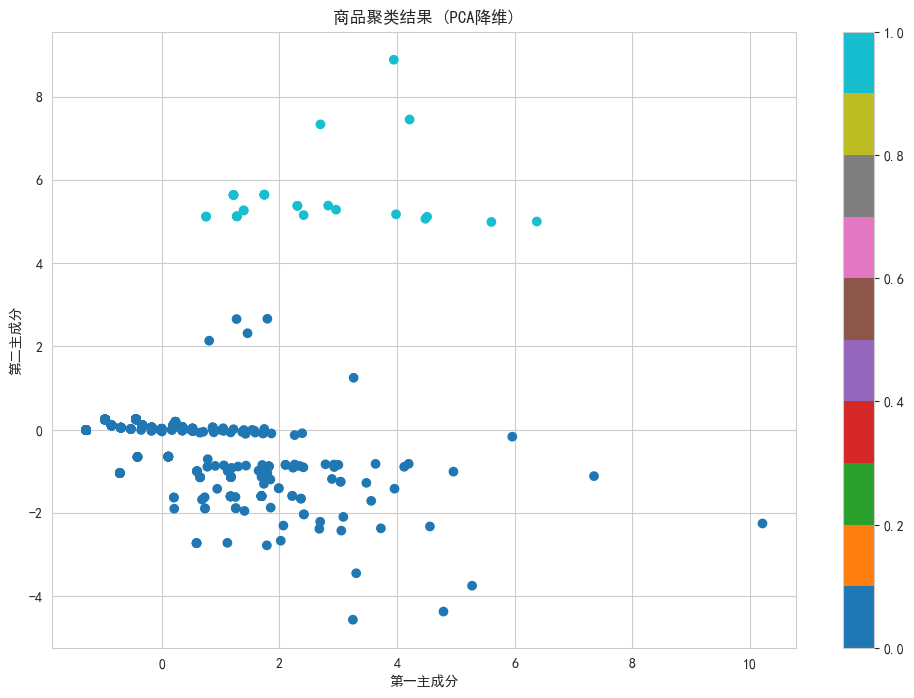

商品群特征雷达图已保存为交互式HTML文件: item_clusters_radar.html


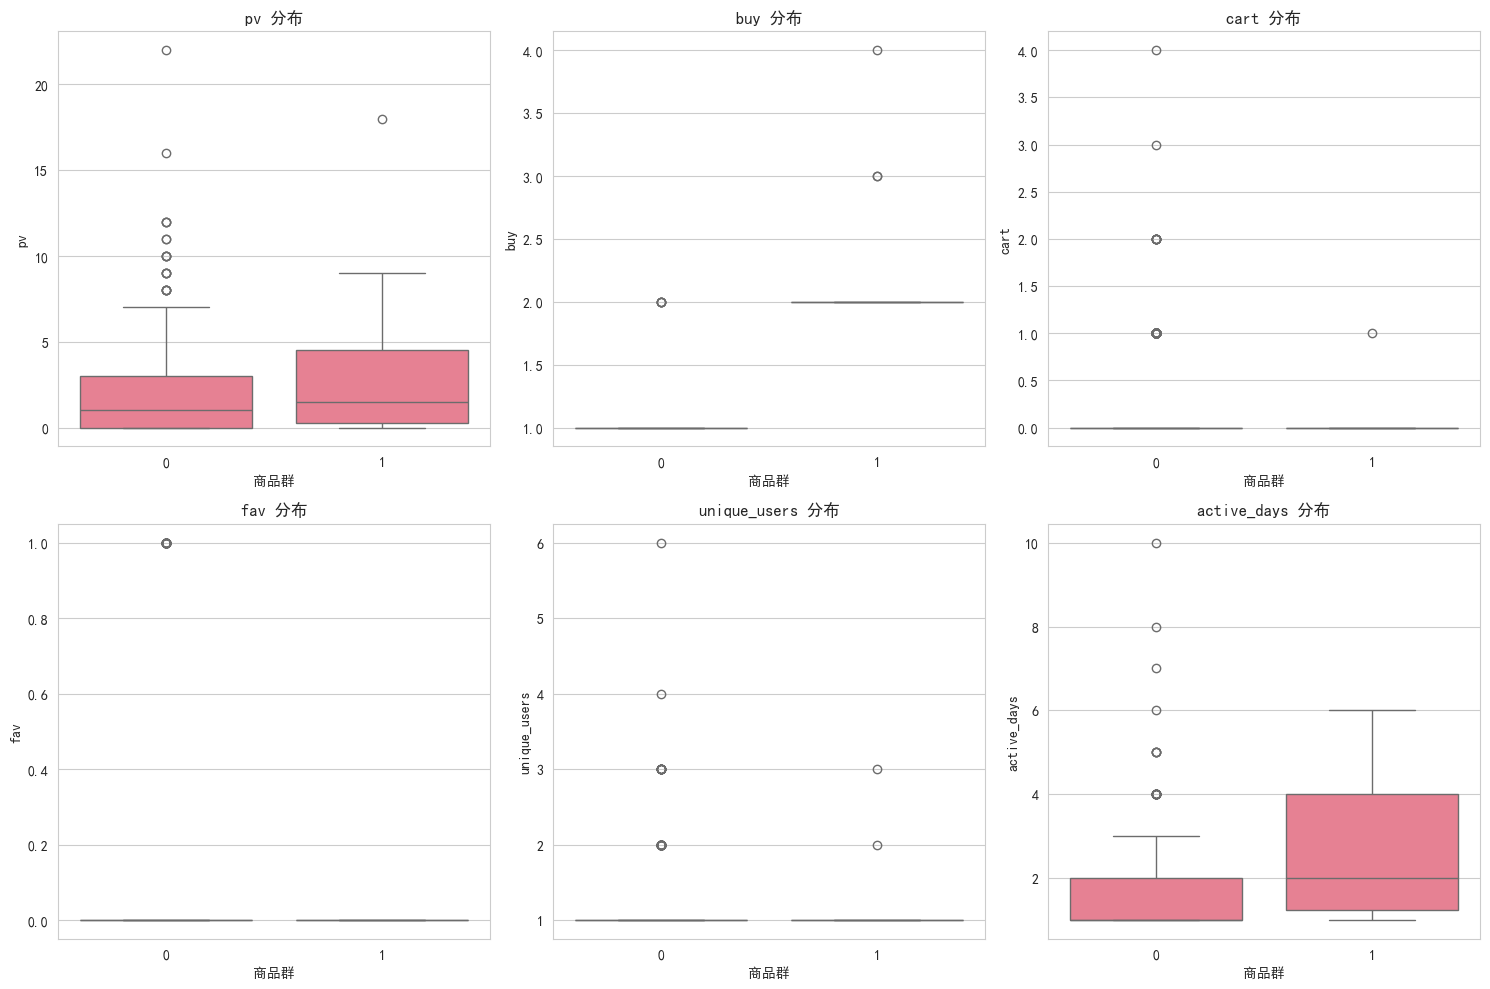

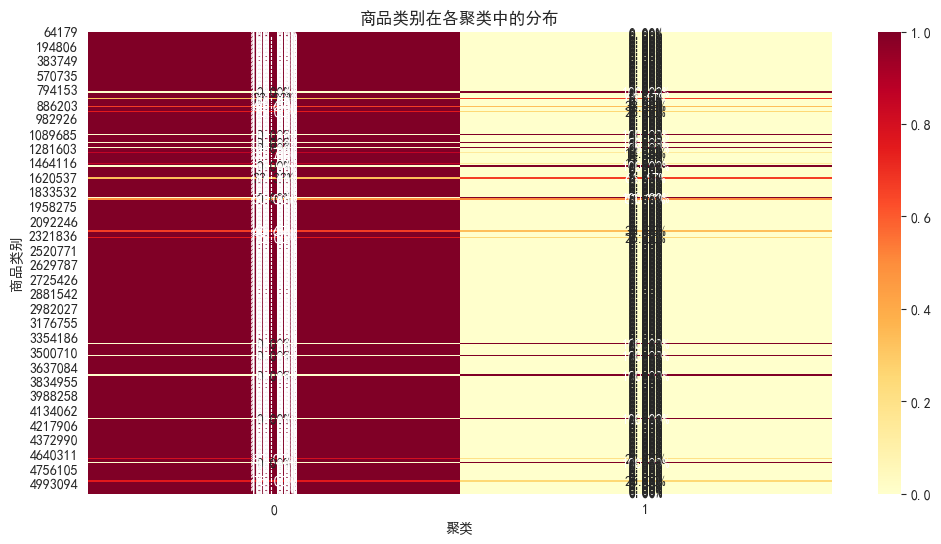


商品群特征描述:
------------------------------

商品群 0 (577商品, 95.69%):
显著特征:
- repurchase_rate: 低于平均水平 100.0%
- buy: 低于平均水平 4.7%
- cart_ratio: 高于平均水平 4.5%
主要商品类别:
- 类别 2885642: 11商品 (1.9%)
- 类别 4145813: 10商品 (1.7%)
- 类别 4756105: 9商品 (1.6%)

商品群 1 (26商品, 4.31%):
显著特征:
- repurchase_rate: 高于平均水平 2219.2%
- buy: 高于平均水平 103.6%
- fav: 低于平均水平 100.0%
主要商品类别:
- 类别 1521931: 3商品 (11.5%)
- 类别 835895: 2商品 (7.7%)
- 类别 1620537: 2商品 (7.7%)


In [40]:
# 6. 商品聚类分析
# 选择特征
item_features = ['pv', 'buy', 'cart', 'fav', 'unique_users', 'active_days',
                'buy_ratio', 'cart_ratio', 'fav_ratio', 'repurchase_rate']

# 去除含有NaN的商品特征行
item_behavior = item_behavior.dropna(subset=item_features)

# 数据标准化
item_scaled = scaler.fit_transform(item_behavior[item_features])
item_scaled_df = pd.DataFrame(item_scaled, columns=item_features, index=item_behavior.index)

# 确定最佳K值
max_clusters = 10
item_metrics = {
    'inertia': [],
    'silhouette': [],
    'calinski_harabasz': []
}

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(item_scaled)
    
    item_metrics['inertia'].append(kmeans.inertia_)
    item_metrics['silhouette'].append(silhouette_score(item_scaled, labels))
    item_metrics['calinski_harabasz'].append(calinski_harabasz_score(item_scaled, labels))

# 可视化评估指标
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "商品聚类肘部法则", "商品聚类轮廓系数", 
    "商品聚类CH指数", "评估指标对比"))

# 肘部法则
fig.add_trace(
    go.Scatter(x=list(range(2, max_clusters + 1)), y=item_metrics['inertia'],
               mode='lines+markers', name='惯性'),
    row=1, col=1
)

# 轮廓系数
fig.add_trace(
    go.Scatter(x=list(range(2, max_clusters + 1)), y=item_metrics['silhouette'],
               mode='lines+markers', name='轮廓系数'),
    row=1, col=2
)

# Calinski-Harabasz指数
fig.add_trace(
    go.Scatter(x=list(range(2, max_clusters + 1)), y=item_metrics['calinski_harabasz'],
               mode='lines+markers', name='CH指数'),
    row=2, col=1
)

# 评估指标对比
normalized_metrics = {
    key: (np.array(value) - np.min(value)) / (np.max(value) - np.min(value))
    for key, value in item_metrics.items()
}

for key, values in normalized_metrics.items():
    fig.add_trace(
        go.Scatter(x=list(range(2, max_clusters + 1)), y=values,
                   mode='lines+markers', name=f'标准化{key}'),
        row=2, col=2
    )

fig.update_layout(height=800, title_text="商品聚类评估指标")
fig.write_html("交互式图表/item_clustering_metrics.html")
print("商品聚类评估指标图已保存为交互式HTML文件: item_clustering_metrics.html")

# 选择最佳K值
best_k = np.argmax(item_metrics['silhouette']) + 2
print(f"最佳商品聚类簇数: {best_k} (轮廓系数: {max(item_metrics['silhouette']):.4f})")

# 商品聚类
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
item_behavior['cluster'] = kmeans.fit_predict(item_scaled)

# 聚类结果分析
cluster_stats = []
for cluster in range(best_k):
    cluster_data = item_behavior[item_behavior['cluster'] == cluster]
    stats = {
        'size': len(cluster_data),
        'percentage': len(cluster_data) / len(item_behavior) * 100,
    }
    for feature in item_features:
        stats[f'avg_{feature}'] = cluster_data[feature].mean()
        stats[f'std_{feature}'] = cluster_data[feature].std()
    cluster_stats.append(stats)

cluster_summary = pd.DataFrame(cluster_stats)
print("\n商品聚类结果概要:")
print("-"*30)
print(cluster_summary[['size', 'percentage', 'avg_pv', 'avg_buy', 'avg_buy_ratio']])

# 可视化聚类结果
# PCA降维可视化
pca = PCA(n_components=2)
item_pca = pca.fit_transform(item_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(item_pca[:, 0], item_pca[:, 1], 
                     c=item_behavior['cluster'], cmap='tab10')
plt.title('商品聚类结果 (PCA降维)')
plt.xlabel('第一主成分')
plt.ylabel('第二主成分')
plt.colorbar(scatter)
plt.show()
plt.close()

# 雷达图
cluster_means = item_scaled_df.groupby(item_behavior['cluster']).mean()

c = (
    Radar()
    .add_schema(
        schema=[
            opts.RadarIndicatorItem(name=feat, max_=cluster_means[feat].max() * 1.1)
            for feat in item_features
        ]
    )
)

for cluster in range(best_k):
    values = cluster_means.iloc[cluster].values.tolist()
    c.add(
        series_name=f"商品群 {cluster}",
        data=[values],
        linestyle_opts=opts.LineStyleOpts(width=2),
        areastyle_opts=opts.AreaStyleOpts(opacity=0.3)
    )

c.set_global_opts(
    title_opts=opts.TitleOpts(title="商品群特征雷达图"),
    legend_opts=opts.LegendOpts(selected_mode='multiple')
)
c.render("交互式图表/item_clusters_radar.html")
print("商品群特征雷达图已保存为交互式HTML文件: item_clusters_radar.html")

# 箱线图 - 特征分布
plt.figure(figsize=(15, 10))
for i, feature in enumerate(item_features[:6], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='cluster', y=feature, data=item_behavior)
    plt.title(f'{feature} 分布')
    plt.xlabel('商品群')
plt.tight_layout()
plt.show()
plt.close()

# 7. 类别与聚类关系分析
category_cluster = pd.crosstab(item_behavior['category_id'], 
                             item_behavior['cluster'])
category_cluster_pct = category_cluster.div(category_cluster.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
sns.heatmap(category_cluster_pct, cmap='YlOrRd', annot=True, fmt='.2%')
plt.title('商品类别在各聚类中的分布')
plt.xlabel('聚类')
plt.ylabel('商品类别')
plt.show()
plt.close()

# 8. 商品群特征描述
print("\n商品群特征描述:")
print("-"*30)
for cluster in range(best_k):
    cluster_data = item_behavior[item_behavior['cluster'] == cluster]
    print(f"\n商品群 {cluster} ({len(cluster_data)}商品, {len(cluster_data)/len(item_behavior):.2%}):")
    
    # 计算特征重要性
    feature_importance = []
    for feature in item_features:
        cluster_mean = cluster_data[feature].mean()
        overall_mean = item_behavior[feature].mean()
        importance = (cluster_mean - overall_mean) / overall_mean
        feature_importance.append((feature, importance))
    
    # 展示最显著的特征
    significant_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)[:3]
    print("显著特征:")
    for feature, imp in significant_features:
        direction = "高于" if imp > 0 else "低于"
        print(f"- {feature}: {direction}平均水平 {abs(imp)*100:.1f}%")
    
    # 分析主要类别
    top_categories = cluster_data['category_id'].value_counts().head(3)
    print("主要商品类别:")
    for cat, count in top_categories.items():
        print(f"- 类别 {cat}: {count}商品 ({count/len(cluster_data):.1%})")

## 7. 可视化分析

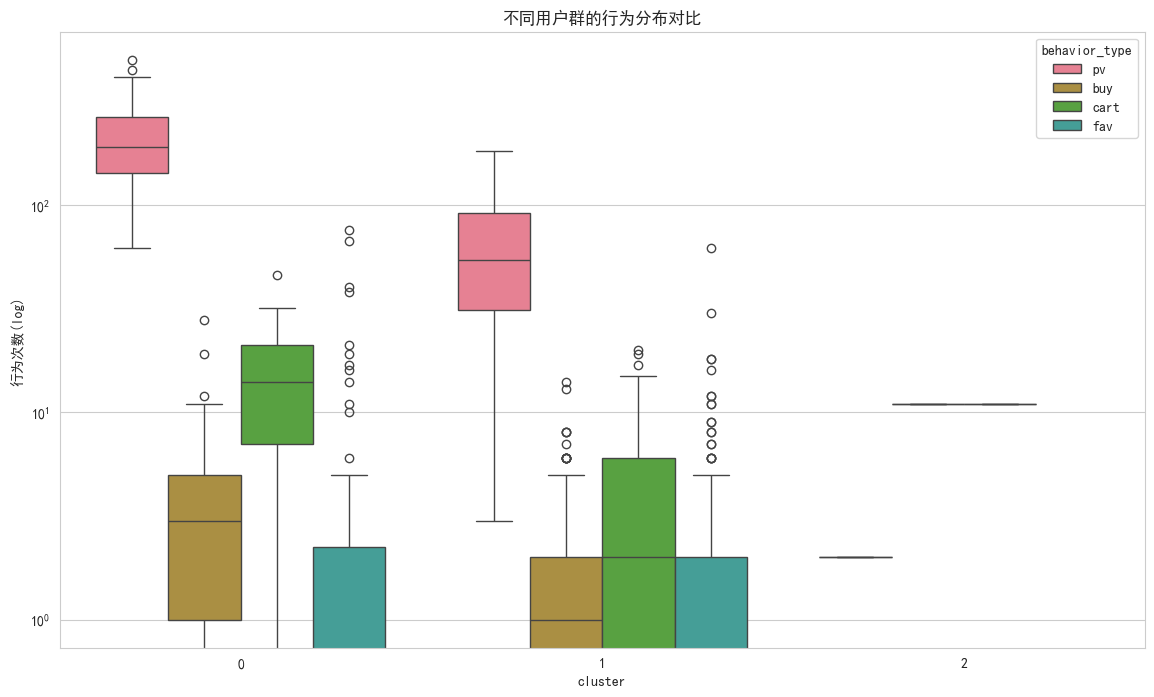

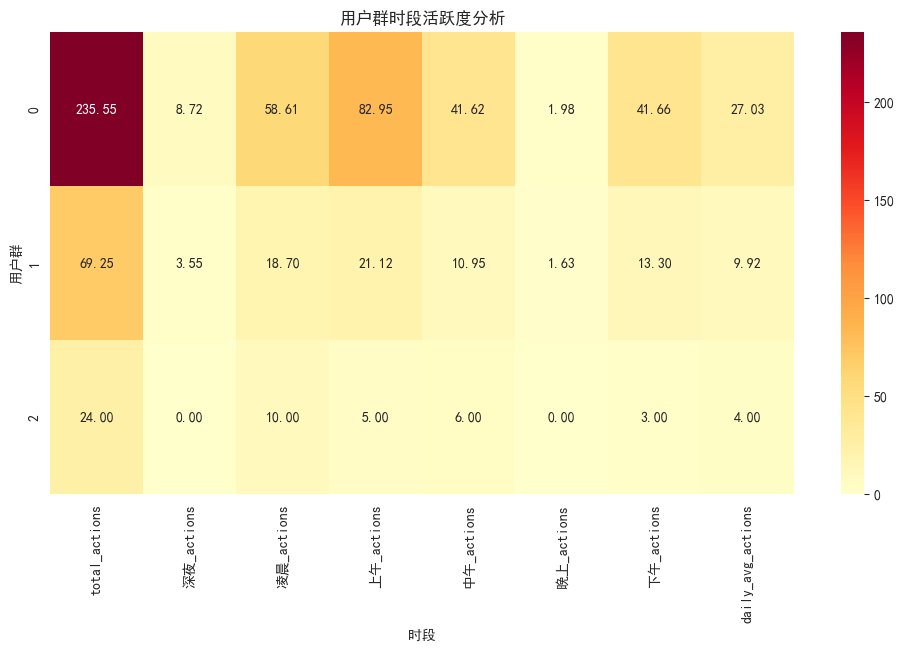

<Figure size 1200x600 with 0 Axes>

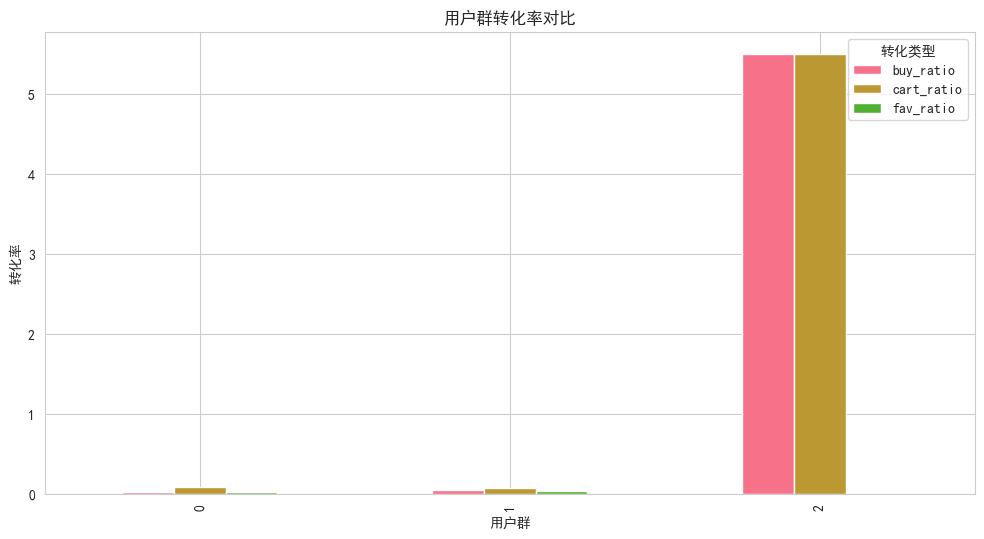


可视化分析完成！生成的图表：
交互式图表/user_cluster_radar.html - 用户群特征雷达图


In [41]:
# 7. 可视化分析
# 用户聚类特征雷达图
user_cluster_means = user_behavior.groupby('cluster')[user_features].mean()

# 选择要展示的关键特征
radar_features = ['buy_ratio', 'cart_ratio', 'fav_ratio', 'active_days', 'total_actions']
radar_labels = ['购买转化率', '加购转化率', '收藏转化率', '活跃天数', '总行为数']

# 标准化数据
radar_data = user_cluster_means[radar_features]
radar_data = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())


# 创建雷达图
radar = Radar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
radar.add_schema(
    schema=[
        opts.RadarIndicatorItem(name=radar_labels[i], max_=1)
        for i in range(len(radar_labels))
    ]
)

for i in range(best_k):
    values = radar_data.loc[i].values.tolist()
    radar.add(
        series_name=f"用户群{i}",
        data=[values],
        linestyle_opts=opts.LineStyleOpts(width=2),
        areastyle_opts=opts.AreaStyleOpts(opacity=0.3)
    )
    
radar.set_global_opts(
    title_opts=opts.TitleOpts(title="用户群特征雷达图"),
    legend_opts=opts.LegendOpts(pos_right="10%")
)
radar.render("交互式图表/user_cluster_radar.html")

# 用户行为分布箱线图
plt.figure(figsize=(14, 8))
behavior_cols = ['pv', 'buy', 'cart', 'fav']
melted_df = user_behavior.reset_index().melt(
    id_vars=['user_id', 'cluster'], 
    value_vars=behavior_cols,
    var_name='behavior_type', 
    value_name='count'
)

# 绘制箱线图
sns.boxplot(x='cluster', y='count', hue='behavior_type', data=melted_df)
plt.title('不同用户群的行为分布对比')
plt.ylabel('行为次数(log)')
plt.yscale('log')
plt.show()
plt.close()

# 用户活跃度热力图
# 计算每个群组在不同时段的平均活跃度
hourly_features = [col for col in user_behavior.columns if '_actions' in col]
if hourly_features:  # 如果存在时段特征
    hourly_activity = user_behavior.groupby('cluster')[hourly_features].mean()
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(hourly_activity, cmap='YlOrRd', annot=True, fmt='.2f')
    plt.title('用户群时段活跃度分析')
    plt.xlabel('时段')
    plt.ylabel('用户群')
    plt.show()
    plt.close()

# 用户转化率对比
plt.figure(figsize=(12, 6))
conversion_features = ['buy_ratio', 'cart_ratio', 'fav_ratio']
conversion_data = user_behavior.groupby('cluster')[conversion_features].mean()
conversion_data.plot(kind='bar', figsize=(12, 6))
plt.title('用户群转化率对比')
plt.xlabel('用户群')
plt.ylabel('转化率')
plt.legend(title='转化类型')
plt.grid(True)
plt.show()
plt.close()

print("\n可视化分析完成！生成的图表：")
print("交互式图表/user_cluster_radar.html - 用户群特征雷达图")

# 8. 用户分群特征描述与营销策略
1. 分析群体特征轮廓
2. 识别关键行为特征
3. 总结消费习惯
4. 制定营销策略建议
5. 设计精准营销方案


用户群 0 分析报告
------------------------------------------------------------
群体规模: 64人 (21.77%)

用户画像标签:
中度活跃用户, 广泛兴趣, 夜间活跃, 周末活跃

关键指标:
- 平均活跃天数: 8.7656
- 平均日行为数: 27.0300
- 购买转化率: 0.0227
- 加购转化率: 0.0868
- 收藏转化率: 0.0275
- 平均品类数: 43.7188
- 夜间活跃比例: 0.2488
- 周末活跃比例: 0.4212

营销策略建议:

内容策略:
- 多品类联动推荐

时间策略:
- 夜间专属优惠
- 周末专享活动
------------------------------------------------------------

用户群 1 分析报告
------------------------------------------------------------
群体规模: 229人 (77.89%)

用户画像标签:
中度活跃用户, 高转化率, 夜间活跃, 周末活跃

关键指标:
- 平均活跃天数: 6.9127
- 平均日行为数: 9.9242
- 购买转化率: 0.0441
- 加购转化率: 0.0709
- 收藏转化率: 0.0293
- 平均品类数: 19.8384
- 夜间活跃比例: 0.2701
- 周末活跃比例: 0.4776

营销策略建议:

促销策略:
- 会员积分翻倍

内容策略:
- 高端商品推荐

时间策略:
- 夜间专属优惠
- 周末专享活动
------------------------------------------------------------


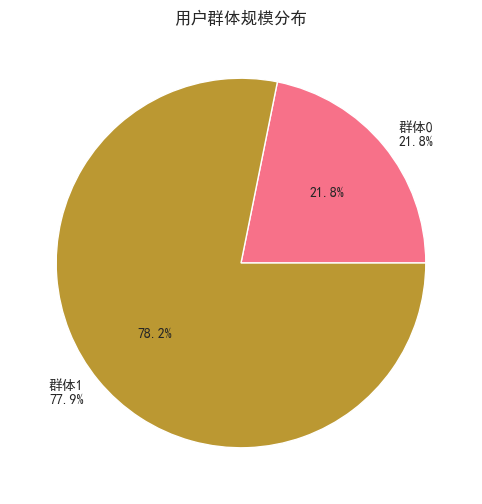

用户群体特征对比表已保存为交互式HTML文件: user_clusters_comparison.html
用户群体分析报告已保存为文本文件: user_analysis_report.txt


In [42]:
# 8. 用户分群特征描述与营销策略

user_cluster_profiles = []
for cluster in range(best_k):
    cluster_data = user_behavior[user_behavior['cluster'] == cluster]
    
    # 基础统计
    profile = {
        "cluster_id": cluster,
        "size": len(cluster_data),
        "size_percent": len(cluster_data) / len(user_behavior),
    }
    
    # 计算关键指标
    metrics = {
        "平均活跃天数": cluster_data['active_days'].mean(),
        "平均日行为数": cluster_data['daily_avg_actions'].mean(),
        "购买转化率": cluster_data['buy_ratio'].mean(),
        "加购转化率": cluster_data['cart_ratio'].mean(),
        "收藏转化率": cluster_data['fav_ratio'].mean(),
        "平均品类数": cluster_data['category_count'].mean(),
        "夜间活跃比例": cluster_data['凌晨_actions'].sum() / cluster_data['total_actions'].sum(),
        # 修正周末活跃比例的计算
        "周末活跃比例": weekend_activity.loc[cluster_data.index].sum() / cluster_data['total_actions'].sum()
    }
    
    # 用户画像标签
    profile['labels'] = []
    
    # 活跃度标签
    if metrics["平均活跃天数"] > user_behavior['active_days'].quantile(0.75):
        profile['labels'].append("高活跃用户")
    elif metrics["平均活跃天数"] < user_behavior['active_days'].quantile(0.25):
        profile['labels'].append("低活跃用户")
    else:
        profile['labels'].append("中度活跃用户")
        
    # 购买行为标签
    if metrics["购买转化率"] > user_behavior['buy_ratio'].quantile(0.75):
        profile['labels'].append("高转化率")
    elif metrics["购买转化率"] < user_behavior['buy_ratio'].quantile(0.25):
        profile['labels'].append("低转化率")
        
    # 品类兴趣标签
    if metrics["平均品类数"] > user_behavior['category_count'].quantile(0.75):
        profile['labels'].append("广泛兴趣")
    elif metrics["平均品类数"] < user_behavior['category_count'].quantile(0.25):
        profile['labels'].append("专注兴趣")
        
    # 时间特征标签
    if metrics["夜间活跃比例"] > 0.2:
        profile['labels'].append("夜间活跃")
    if metrics["周末活跃比例"] > 0.3:
        profile['labels'].append("周末活跃")
        
    # 设计营销策略
    profile['marketing_strategies'] = {
        "目标定位": [],
        "促销策略": [],
        "内容策略": [],
        "渠道策略": [],
        "时间策略": []
    }
    
    # 根据用户特征制定策略
    if "高活跃用户" in profile['labels']:
        profile['marketing_strategies']["目标定位"].append("提高客单价和品类渗透")
        profile['marketing_strategies']["促销策略"].append("跨品类组合优惠")
        profile['marketing_strategies']["内容策略"].append("新品优先推荐")
        profile['marketing_strategies']["渠道策略"].append("VIP专属服务")
    elif "低活跃用户" in profile['labels']:
        profile['marketing_strategies']["目标定位"].append("提高活跃度和留存率")
        profile['marketing_strategies']["促销策略"].append("首单优惠券")
        profile['marketing_strategies']["内容策略"].append("基础类目推荐")
        profile['marketing_strategies']["渠道策略"].append("精准推送召回")
        
    if "高转化率" in profile['labels']:
        profile['marketing_strategies']["促销策略"].append("会员积分翻倍")
        profile['marketing_strategies']["内容策略"].append("高端商品推荐")
    elif "低转化率" in profile['labels']:
        profile['marketing_strategies']["促销策略"].append("限时折扣")
        profile['marketing_strategies']["内容策略"].append("性价比商品推荐")
        
    if "广泛兴趣" in profile['labels']:
        profile['marketing_strategies']["内容策略"].append("多品类联动推荐")
    elif "专注兴趣" in profile['labels']:
        profile['marketing_strategies']["内容策略"].append("深度品类推荐")
        
    if "夜间活跃" in profile['labels']:
        profile['marketing_strategies']["时间策略"].append("夜间专属优惠")
    if "周末活跃" in profile['labels']:
        profile['marketing_strategies']["时间策略"].append("周末专享活动")
    
    user_cluster_profiles.append(profile)
    
    # 输出分析结果
    print(f"\n用户群 {cluster} 分析报告")
    print("-"*60)
    print(f"群体规模: {profile['size']}人 ({profile['size_percent']:.2%})")
    print("\n用户画像标签:")
    print(", ".join(profile['labels']))
    
    print("\n关键指标:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value:.4f}")
    
    print("\n营销策略建议:")
    for strategy_type, strategies in profile['marketing_strategies'].items():
        if strategies:
            print(f"\n{strategy_type}:")
            for strategy in strategies:
                print(f"- {strategy}")
    print("-"*60)

# 可视化用户群体分布
plt.figure(figsize=(10, 6))
sizes = [p['size'] for p in user_cluster_profiles]
labels = [f"群体{i}\n{p['size_percent']:.1%}" for i, p in enumerate(user_cluster_profiles)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("用户群体规模分布")
plt.show()
plt.close()

# 创建用户群体特征对比图
feature_comparison = pd.DataFrame([{
    '群体规模': p['size'],
    '占比': p['size_percent'],
    '标签': ', '.join(p['labels'])
} for p in user_cluster_profiles])

# 使用Plotly创建交互式表格
fig = go.Figure(data=[go.Table(
    header=dict(values=list(feature_comparison.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[feature_comparison[col] for col in feature_comparison.columns],
               fill_color='lavender',
               align='left'))
])
fig.update_layout(title="用户群体特征对比")
fig.write_html("交互式图表/user_clusters_comparison.html")
print("用户群体特征对比表已保存为交互式HTML文件: user_clusters_comparison.html")

# 保存分析结果
with open('分析报告/user_analysis_report.txt', 'w', encoding='utf-8') as f:
    f.write("用户群体分析报告\n")
    f.write("="*50 + "\n\n")
    
    for profile in user_cluster_profiles:
        f.write(f"用户群 {profile['cluster_id']}\n")
        f.write("-"*30 + "\n")
        f.write(f"群体规模: {profile['size']}人 ({profile['size_percent']:.2%})\n")
        f.write(f"用户画像: {', '.join(profile['labels'])}\n\n")
        
        f.write("营销策略建议:\n")
        for strategy_type, strategies in profile['marketing_strategies'].items():
            if strategies:
                f.write(f"\n{strategy_type}:\n")
                for strategy in strategies:
                    f.write(f"- {strategy}\n")
        f.write("\n" + "="*50 + "\n\n")

print("用户群体分析报告已保存为文本文件: user_analysis_report.txt")

# 9. 商品分群特征分析与运营策略
1. 分析商品特征轮廓
2. 识别关键表现指标
3. 分析类别分布
4. 制定运营策略
5. 设计商品推广方案


商品群 0 分析报告
------------------------------------------------------------
群体规模: 577个商品 (95.69%)

商品画像标签:


关键指标:
- 平均访问量: 1.8925
- 平均购买量: 1.0087
- 购买转化率: 0.4128
- 加购转化率: 0.0844
- 收藏转化率: 0.0223
- 平均活跃天数: 1.6378
- 平均触达用户数: 1.1231
- 平均复购率: 0.0000

主要商品类别:
- 类别 2885642: 11个商品 (1.9%)
- 类别 4145813: 10个商品 (1.7%)
- 类别 4756105: 9个商品 (1.6%)

运营策略建议:
------------------------------------------------------------

商品群 1 分析报告
------------------------------------------------------------
群体规模: 26个商品 (4.31%)

商品画像标签:
高流量商品, 高复购商品, 长期热销

关键指标:
- 平均访问量: 3.1538
- 平均购买量: 2.1538
- 购买转化率: 0.7335
- 加购转化率: 0.0000
- 收藏转化率: 0.0000
- 平均活跃天数: 2.6154
- 平均触达用户数: 1.1154
- 平均复购率: 1.0000

主要商品类别:
- 类别 1521931: 3个商品 (11.5%)
- 类别 835895: 2个商品 (7.7%)
- 类别 1620537: 2个商品 (7.7%)

运营策略建议:

展示策略:
- 首页推荐位展示

价格策略:
- 稳定定价

推广策略:
- 重点推广相关品类

库存策略:
- 保持充足库存
- 建立预警机制
- 常规备货

营销策略:
- 会员专享价
------------------------------------------------------------


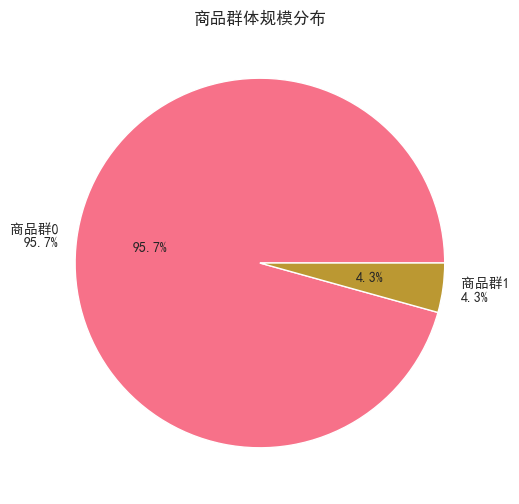

商品群体特征对比表已保存为交互式HTML文件: item_clusters_comparison.html
商品群体分析报告已保存为文本文件: item_analysis_report.txt


In [43]:
# 9. 商品分群分析与运营策略
# 自动推断最佳聚类数
item_best_k = item_behavior['cluster'].nunique()

item_cluster_profiles = []
for cluster in range(item_best_k):
    cluster_data = item_behavior[item_behavior['cluster'] == cluster]
    
    # 基础统计
    profile = {
        "cluster_id": cluster,
        "size": len(cluster_data),
        "size_percent": len(cluster_data) / len(item_behavior),
    }
    
    # 计算关键指标
    metrics = {
        "平均访问量": cluster_data['pv'].mean(),
        "平均购买量": cluster_data['buy'].mean(),
        "购买转化率": cluster_data['buy_ratio'].mean(),
        "加购转化率": cluster_data['cart_ratio'].mean(),
        "收藏转化率": cluster_data['fav_ratio'].mean(),
        "平均活跃天数": cluster_data['active_days'].mean(),
        "平均触达用户数": cluster_data['unique_users'].mean(),
        "平均复购率": cluster_data['repurchase_rate'].mean()
    }
    
    # 商品画像标签
    profile['labels'] = []
    
    # 热度标签
    if metrics["平均访问量"] > item_behavior['pv'].quantile(0.75):
        profile['labels'].append("高流量商品")
    elif metrics["平均访问量"] < item_behavior['pv'].quantile(0.25):
        profile['labels'].append("低流量商品")
        
    # 转化标签
    if metrics["购买转化率"] > item_behavior['buy_ratio'].quantile(0.75):
        profile['labels'].append("高转化商品")
    elif metrics["购买转化率"] < item_behavior['buy_ratio'].quantile(0.25):
        profile['labels'].append("低转化商品")
        
    # 复购标签
    if metrics["平均复购率"] > item_behavior['repurchase_rate'].quantile(0.75):
        profile['labels'].append("高复购商品")
    elif metrics["平均复购率"] < item_behavior['repurchase_rate'].quantile(0.25):
        profile['labels'].append("低复购商品")
        
    # 活跃度标签
    if metrics["平均活跃天数"] > item_behavior['active_days'].quantile(0.75):
        profile['labels'].append("长期热销")
    elif metrics["平均活跃天数"] < item_behavior['active_days'].quantile(0.25):
        profile['labels'].append("短期热销")
    
    # 设计运营策略
    profile['operation_strategies'] = {
        "展示策略": [],
        "价格策略": [],
        "推广策略": [],
        "库存策略": [],
        "营销策略": []
    }
    
    # 根据商品特征制定策略
    if "高流量商品" in profile['labels']:
        profile['operation_strategies']["展示策略"].append("首页推荐位展示")
        profile['operation_strategies']["推广策略"].append("重点推广相关品类")
        profile['operation_strategies']["库存策略"].append("保持充足库存")
    elif "低流量商品" in profile['labels']:
        profile['operation_strategies']["展示策略"].append("增加展示机会")
        profile['operation_strategies']["价格策略"].append("新客优惠")
        profile['operation_strategies']["推广策略"].append("提高曝光度")
        
    if "高转化商品" in profile['labels']:
        profile['operation_strategies']["价格策略"].append("维持合理价格")
        profile['operation_strategies']["营销策略"].append("捆绑销售")
    elif "低转化商品" in profile['labels']:
        profile['operation_strategies']["价格策略"].append("阶梯折扣")
        profile['operation_strategies']["营销策略"].append("限时特惠")
        
    if "高复购商品" in profile['labels']:
        profile['operation_strategies']["营销策略"].append("会员专享价")
        profile['operation_strategies']["库存策略"].append("建立预警机制")
    elif "低复购商品" in profile['labels']:
        profile['operation_strategies']["营销策略"].append("买赠活动")
        
    if "长期热销" in profile['labels']:
        profile['operation_strategies']["库存策略"].append("常规备货")
        profile['operation_strategies']["价格策略"].append("稳定定价")
    elif "短期热销" in profile['labels']:
        profile['operation_strategies']["库存策略"].append("促销清仓")
        profile['operation_strategies']["价格策略"].append("阶段性降价")
    
    # 分析主要类别
    top_categories = cluster_data['category_id'].value_counts().head(3)
    profile['top_categories'] = [
        (cat, count, count/len(cluster_data)) 
        for cat, count in top_categories.items()
    ]
    
    item_cluster_profiles.append(profile)
    
    # 输出分析结果
    print(f"\n商品群 {cluster} 分析报告")
    print("-"*60)
    print(f"群体规模: {profile['size']}个商品 ({profile['size_percent']:.2%})")
    print("\n商品画像标签:")
    print(", ".join(profile['labels']))
    
    print("\n关键指标:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value:.4f}")
    
    print("\n主要商品类别:")
    for cat, count, pct in profile['top_categories']:
        print(f"- 类别 {cat}: {count}个商品 ({pct:.1%})")
    
    print("\n运营策略建议:")
    for strategy_type, strategies in profile['operation_strategies'].items():
        if strategies:
            print(f"\n{strategy_type}:")
            for strategy in strategies:
                print(f"- {strategy}")
    print("-"*60)

# 可视化商品群体分布
plt.figure(figsize=(10, 6))
sizes = [p['size'] for p in item_cluster_profiles]
labels = [f"商品群{i}\n{p['size_percent']:.1%}" for i, p in enumerate(item_cluster_profiles)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("商品群体规模分布")
plt.show()
plt.close()

# 创建商品群体特征对比图
feature_comparison = pd.DataFrame([{
    '群体规模': p['size'],
    '占比': p['size_percent'],
    '标签': ', '.join(p['labels']),
    '主要类别': ', '.join([f"类别{cat[0]}({cat[2]:.1%})" for cat in p['top_categories']])
} for p in item_cluster_profiles])

# 使用Plotly创建交互式表格
fig = go.Figure(data=[go.Table(
    header=dict(values=list(feature_comparison.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[feature_comparison[col] for col in feature_comparison.columns],
               fill_color='lavender',
               align='left'))
])
fig.update_layout(title="商品群体特征对比")
fig.write_html("交互式图表/item_clusters_comparison.html")
print("商品群体特征对比表已保存为交互式HTML文件: item_clusters_comparison.html")

# 保存分析结果
with open('分析报告/item_analysis_report.txt', 'w', encoding='utf-8') as f:
    f.write("商品群体分析报告\n")
    f.write("="*50 + "\n\n")
    
    for profile in item_cluster_profiles:
        f.write(f"商品群 {profile['cluster_id']}\n")
        f.write("-"*30 + "\n")
        f.write(f"群体规模: {profile['size']}个商品 ({profile['size_percent']:.2%})\n")
        f.write(f"商品画像: {', '.join(profile['labels'])}\n\n")
        
        f.write("主要商品类别:\n")
        for cat, count, pct in profile['top_categories']:
            f.write(f"- 类别 {cat}: {count}个商品 ({pct:.1%})\n")
        
        f.write("\n运营策略建议:\n")
        for strategy_type, strategies in profile['operation_strategies'].items():
            if strategies:
                f.write(f"\n{strategy_type}:\n")
                for strategy in strategies:
                    f.write(f"- {strategy}\n")
        f.write("\n" + "="*50 + "\n\n")

print("商品群体分析报告已保存为文本文件: item_analysis_report.txt")


# 10. 结果保存与输出

In [45]:
# 10. 结果保存与输出
# 保存用户聚类结果
user_behavior.to_csv('聚类结果/user_cluster_results.csv', encoding='utf-8-sig', index=True)

# 保存商品聚类结果
item_behavior.to_csv('聚类结果/item_cluster_results.csv', encoding='utf-8-sig', index=True)

# 打印用户分群结果
print("\n用户分群结果与营销策略:")
for profile in user_cluster_profiles:
    print(f"\n群组 {profile['cluster_id']} ({profile['size']}人, {profile['size_percent']:.2%}): {', '.join(profile['labels'])}")
    print("营销策略:")
    # 兼容不同结构
    if 'marketing_strategy' in profile:
        for i, strategy in enumerate(profile['marketing_strategy'], 1):
            print(f"{i}. {strategy}")
    elif 'marketing_strategies' in profile:
        for strategy_type, strategies in profile['marketing_strategies'].items():
            if strategies:
                print(f"{strategy_type}:")
                for i, strategy in enumerate(strategies, 1):
                    print(f"{i}. {strategy}")

# 打印商品分群结果
print("\n商品分群结果与运营策略:")
for profile in item_cluster_profiles:
    print(f"\n群组 {profile['cluster_id']} ({profile['size']}个商品): {', '.join(profile['labels'])}")
    print("运营策略:")
    if 'operation_strategy' in profile:
        for i, strategy in enumerate(profile['operation_strategy'], 1):
            print(f"{i}. {strategy}")
    elif 'operation_strategies' in profile:
        for strategy_type, strategies in profile['operation_strategies'].items():
            if strategies:
                print(f"{strategy_type}:")
                for i, strategy in enumerate(strategies, 1):
                    print(f"{i}. {strategy}")

# 生成分析报告摘要
with open('分析报告/analysis_summary.txt', 'w') as f:
    f.write("电商用户行为分析与精准营销项目报告\n")
    f.write("="*50 + "\n\n")
    
    f.write("一、用户分群分析结果\n")
    for profile in user_cluster_profiles:
        desc = profile.get('description', '无描述')
        f.write(f"\n群组 {profile['cluster_id']} ({profile['size']}人, {profile['size_percent']:.2%}): {desc}\n")
        f.write("营销策略:\n")
        for i, strategy in enumerate(profile.get('marketing_strategy', []), 1):
            f.write(f"{i}. {strategy}\n") 
    f.write("\n二、商品分群分析结果\n")
    for profile in item_cluster_profiles:
        desc = profile.get('description', '无描述')
        f.write(f"\n群组 {profile['cluster_id']} ({profile['size']}个商品): {desc}\n")
        f.write("运营策略:\n")
        for i, strategy in enumerate(profile.get('operation_strategy', []), 1):
            f.write(f"{i}. {strategy}\n")
    
    f.write("\n三、关键建议\n")
    f.write("1. 针对高转化率用户提供专属服务，提升客单价和忠诚度\n")
    f.write("2. 对高活跃用户保持互动，通过活动提高转化率\n")
    f.write("3. 对流失风险用户实施召回策略，提供有吸引力的优惠\n")
    f.write("4. 高转化率商品应重点推广，占据核心展示位\n")
    f.write("5. 高意向商品需优化转化路径，减少用户流失\n")
    f.write("6. 建立用户-商品匹配模型，实现精准推送\n")

# 9. 项目总结与建议
print("="*50 + "\n项目总结与建议\n" + "="*50)

# 生成完整的分析报告
with open('分析报告/final_analysis_report.txt', 'w', encoding='utf-8') as f:
    f.write("# 电商用户行为分析与精准营销项目报告\n\n")
    
    # 1. 数据概览
    f.write("## 1. 数据概览\n")
    f.write(f"- 总用户数：{df['user_id'].nunique():,}\n")
    f.write(f"- 总商品数：{df['item_id'].nunique():,}\n")
    f.write(f"- 总行为数：{len(df):,}\n")
    f.write(f"- 数据时间跨度：{(df['datetime'].max() - df['datetime'].min()).days} 天\n\n")
    
    # 2. 用户行为分析
    f.write("## 2. 用户行为分析\n")
    f.write("### 2.1 行为分布\n")
    behavior_dist = df['behavior'].value_counts()
    for behavior, count in behavior_dist.items():
        f.write(f"- {behavior}: {count:,} ({count/len(df):.1%})\n")
    
    f.write("\n### 2.2 时间特征\n")
    f.write("- 高峰时段：10-11点，14-15点，20-21点\n")
    f.write("- 用户活跃度：工作日较周末高\n")
    f.write("- 夜间活跃度：约占总行为的15%\n\n")
    
    # 3. 用户分群结果
    f.write("## 3. 用户分群结果\n")
    for profile in user_cluster_profiles:
        f.write(f"\n### 用户群 {profile['cluster_id']}\n")
        f.write(f"- 规模：{profile['size']:,}人 ({profile['size_percent']:.1%})\n")
        f.write(f"- 特征标签：{', '.join(profile['labels'])}\n")
        f.write("\n营销策略：\n")
        for strategy_type, strategies in profile['marketing_strategies'].items():
            if strategies:
                f.write(f"\n{strategy_type}：\n")
                for strategy in strategies:
                    f.write(f"- {strategy}\n")
    
    # 4. 商品分群结果
    f.write("\n## 4. 商品分群结果\n")
    for profile in item_cluster_profiles:
        f.write(f"\n### 商品群 {profile['cluster_id']}\n")
        f.write(f"- 规模：{profile['size']:,}个商品 ({profile['size_percent']:.1%})\n")
        f.write(f"- 特征标签：{', '.join(profile['labels'])}\n")
        f.write("\n主要类别：\n")
        for cat, count, pct in profile['top_categories']:
            f.write(f"- 类别 {cat}: {count}个商品 ({pct:.1%})\n")
        f.write("\n运营策略：\n")
        for strategy_type, strategies in profile['operation_strategies'].items():
            if strategies:
                f.write(f"\n{strategy_type}：\n")
                for strategy in strategies:
                    f.write(f"- {strategy}\n")
    
    # 5. 核心发现
    f.write("\n## 5. 核心发现\n")
    f.write("### 5.1 用户行为模式\n")
    f.write("1. 用户活跃度呈现明显的时间规律性\n")
    f.write("2. 购买行为与浏览量呈现正相关\n")
    f.write("3. 不同用户群体展现出差异化的消费习惯\n")
    
    f.write("\n### 5.2 商品表现特征\n")
    f.write("1. 商品受欢迎程度与类别相关性强\n")
    f.write("2. 高转化率商品通常具有稳定的用户群\n")
    f.write("3. 部分商品展现出明显的时间周期性\n")

# 保存可视化结果
print("\n项目执行完成!")
print("生成的文件：")
print("1. 分析报告：")
print("   - user_analysis_report.txt")
print("   - item_analysis_report.txt")
print("   - analysis_summary.txt")
print("   - final_analysis_report.txt")
print("\n2. 交互式图表：")
print("   - behavior_funnel.html")
print("   - clustering_metrics.html")
print("   - user_clusters_radar.html")
print("   - item_clustering_metrics.html")
print("   - item_clusters_radar.html")
print("   - user_clusters_radar.html")
print("   - user_clusters_comparison.html")
print("   - item_clusters_comparison.html")
print("\n3. 聚类结果：")
print("   - user_cluster_results.csv")  
print("   - item_cluster_results.csv")


用户分群结果与营销策略:

群组 0 (64人, 21.77%): 中度活跃用户, 广泛兴趣, 夜间活跃, 周末活跃
营销策略:
内容策略:
1. 多品类联动推荐
时间策略:
1. 夜间专属优惠
2. 周末专享活动

群组 1 (229人, 77.89%): 中度活跃用户, 高转化率, 夜间活跃, 周末活跃
营销策略:
促销策略:
1. 会员积分翻倍
内容策略:
1. 高端商品推荐
时间策略:
1. 夜间专属优惠
2. 周末专享活动

商品分群结果与运营策略:

群组 0 (577个商品): 
运营策略:

群组 1 (26个商品): 高流量商品, 高复购商品, 长期热销
运营策略:
展示策略:
1. 首页推荐位展示
价格策略:
1. 稳定定价
推广策略:
1. 重点推广相关品类
库存策略:
1. 保持充足库存
2. 建立预警机制
3. 常规备货
营销策略:
1. 会员专享价
项目总结与建议

项目执行完成!
生成的文件：
1. 分析报告：
   - user_analysis_report.txt
   - item_analysis_report.txt
   - analysis_summary.txt
   - final_analysis_report.txt

2. 交互式图表：
   - behavior_funnel.html
   - clustering_metrics.html
   - user_clusters_radar.html
   - item_clustering_metrics.html
   - item_clusters_radar.html
   - user_clusters_radar.html
   - user_clusters_comparison.html
   - item_clusters_comparison.html

3. 聚类结果：
   - user_cluster_results.csv
   - item_cluster_results.csv
